***Importamos las librerías necesarias :***

In [1]:
import os
import torch
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
from io import BytesIO
from pathlib import Path
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.models import alexnet, AlexNet_Weights
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from torchvision.models import densenet121, DenseNet121_Weights
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

***Guardamos las imágenes con sus respectivas clases en "complete_df" :***

In [2]:
image_dir = Path('./Imagenes/Trayectorias_dominio_tiempo_frecuencia/longitud_28/raw-img-v5')

file_paths = list(image_dir.rglob("*.jpg")) + \
             list(image_dir.rglob("*.jpeg")) + \
             list(image_dir.rglob("*.png"))

complete_df = pd.DataFrame()
complete_df['file_name'] = [str(p) for p in file_paths]
complete_df['class_name'] = complete_df['file_name'].map(lambda x: Path(x).parent.name)

### COMPROBACIÓN ###
print("Número total de imágenes:", len(complete_df))
class_counts = complete_df['class_name'].value_counts()
print(class_counts)


Número total de imágenes: 13668
class_name
AIS(37)       4160
AIS(31-32)    3260
AIS(70-79)    1216
AIS(90-99)    1058
AIS(36)       1014
AIS(60-69)     993
AIS(30)        896
AIS(80-89)     570
AIS(52)        310
AIS(56-57)     191
Name: count, dtype: int64


***Dividimos "complete_df" en entrenamiento y test :***

In [3]:
complete_df = complete_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_size = 0.2
train_df_list = []
test_df_list = []

classes = complete_df['class_name'].unique()

for class_name in classes:
    class_subset = complete_df[complete_df['class_name'] == class_name]
    
    test_count = int(len(class_subset) * test_size)
    
    test_df_list.append(class_subset.iloc[:test_count])
    train_df_list.append(class_subset.iloc[test_count:])

train_df = pd.concat(train_df_list).reset_index(drop=True)
test_df = pd.concat(test_df_list).reset_index(drop=True)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

#### COMPROBACIÓN ####
print(f"Nº de imágenes en train: {len(train_df)}")
print(train_df['class_name'].value_counts())
print()
print(f"Nº de imágenes en test: {len(test_df)}")
print(test_df['class_name'].value_counts())
print()
print("Ejm. conjunto train:")
print(train_df.head(10))
print()
print("Ejm. conjunto test:")
print(test_df.head(10))

Nº de imágenes en train: 10937
class_name
AIS(37)       3328
AIS(31-32)    2608
AIS(70-79)     973
AIS(90-99)     847
AIS(36)        812
AIS(60-69)     795
AIS(30)        717
AIS(80-89)     456
AIS(52)        248
AIS(56-57)     153
Name: count, dtype: int64

Nº de imágenes en test: 2731
class_name
AIS(37)       832
AIS(31-32)    652
AIS(70-79)    243
AIS(90-99)    211
AIS(36)       202
AIS(60-69)    198
AIS(30)       179
AIS(80-89)    114
AIS(52)        62
AIS(56-57)     38
Name: count, dtype: int64

Ejm. conjunto train:
                                           file_name  class_name
0  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     AIS(37)
1  Imagenes\Trayectorias_dominio_tiempo_frecuenci...  AIS(31-32)
2  Imagenes\Trayectorias_dominio_tiempo_frecuenci...  AIS(60-69)
3  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     AIS(36)
4  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     AIS(37)
5  Imagenes\Trayectorias_dominio_tiempo_frecuenci...  AIS(56-57)
6  Imagenes\Trayec

***Imágenes de entrenamiento y test antes del pre-procesado :***

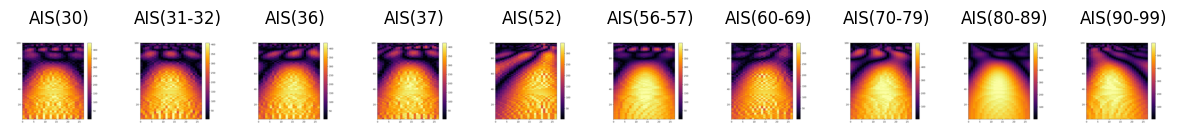

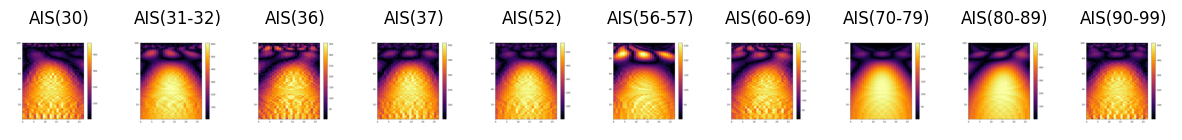

In [4]:
def mostrar_imagenes_antes_preprocesado(df):
    plt.figure(figsize=(15, 15))
    grouped = df.groupby('class_name')
    
    for i, (class_name, group) in enumerate(grouped):
        image_path = group['file_name'].iloc[0]
        image = Image.open(image_path).convert("RGB")
        
        plt.subplot(1, len(grouped), i + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')
    
    plt.show()

mostrar_imagenes_antes_preprocesado(train_df)
mostrar_imagenes_antes_preprocesado(test_df)


***Pre-procesado de las imágenes :***

In [5]:
IMG_SIZE = (227, 227)
X_train = []
y_train = []
X_test = []
y_test = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} disponible")

transform = transforms.Compose([transforms.Resize(IMG_SIZE),transforms.ToTensor()])

def preprocesado_imagen(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image

for index, row in train_df.iterrows():
    image_tensor = preprocesado_imagen(row['file_name'])
    X_train.append(image_tensor)
    y_train.append(row['class_name'])

for index, row in test_df.iterrows():
    image_tensor = preprocesado_imagen(row['file_name'])
    X_test.append(image_tensor)
    y_test.append(row['class_name'])

X_train = torch.stack(X_train)
X_test = torch.stack(X_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train = torch.tensor(y_train_encoded, dtype=torch.long)
y_test = torch.tensor(y_test_encoded, dtype=torch.long)

### COMPROBACIÓN ###
print("X_train:", X_train.shape, X_train.device)
print("y_train:", y_train.shape, y_train.device)
print("X_test:", X_test.shape, X_test.device)
print("y_test:", y_test.shape, y_test.device)


cuda disponible
X_train: torch.Size([10937, 3, 227, 227]) cpu
y_train: torch.Size([10937]) cpu
X_test: torch.Size([2731, 3, 227, 227]) cpu
y_test: torch.Size([2731]) cpu


# ***AlexNet :***

In [ ]:
def get_alexnet_model(num_classes, pretrained):
    if pretrained:
        modelo = alexnet(weights=AlexNet_Weights.DEFAULT)
    else:
        modelo = alexnet(weights=None)

    modelo.classifier[6] = nn.Linear(modelo.classifier[6].in_features, num_classes)

    if pretrained:
        for param in modelo.features.parameters():
            param.requires_grad = False
            
        for param in modelo.classifier[6].parameters():
            param.requires_grad = True

    return modelo

# ***ResNet50 :***

In [6]:
def get_resnet50_model(num_classes, pretrained):
    if pretrained:
        modelo = resnet50(weights=ResNet50_Weights.DEFAULT)
    else:
        modelo = resnet50(weights=None)

    modelo.fc = nn.Linear(modelo.fc.in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.fc.parameters():
            param.requires_grad = True

    return modelo

# ***DenseNet121 :***

In [ ]:
def get_densenet121_model(num_classes, pretrained):
    if pretrained:
        modelo = densenet121(weights=DenseNet121_Weights.DEFAULT)
    else:
        modelo = densenet121(weights=None)

    modelo.classifier = nn.Linear(modelo.classifier.in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.classifier.parameters():
            param.requires_grad = True

    return modelo

# ***ConvNeXt Tiny :***

In [6]:
def get_convnext_tiny_model(num_classes, pretrained):
    if pretrained:
        modelo = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)
    else:
        modelo = convnext_tiny(weights=None)

    modelo.classifier[2] = nn.Linear(modelo.classifier[2].in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.classifier[2].parameters():
            param.requires_grad = True

    return modelo

***Configuración del modelo :***

In [7]:
k_folds = 5
batch_size = 32
num_epochs = 100
num_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

***Entrenamiento del modelo :***

In [8]:
train_dataset = TensorDataset(X_train, y_train)
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_train_acc = []
fold_train_loss = []
fold_val_acc = []
fold_val_loss = []

best_val_acc = 0
best_epoch_train_acc = []
best_epoch_val_acc = []
best_epoch_train_loss = []
best_epoch_val_loss = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):

    epoch_train_acc = []
    epoch_val_acc = []
    epoch_train_loss = []
    epoch_val_loss = []

    print(f"\n📂 Fold {fold+1}/{k_folds}")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

    #nombre_modelo = "AlexNet"
    #modelo = get_alexnet_model(num_classes=num_classes, pretrained=False).to(device)
    
    nombre_modelo = "ResNet50"
    modelo = get_resnet50_model(num_classes=num_classes, pretrained=True).to(device)
    
    #nombre_modelo = "DenseNet121"
    #modelo = get_densenet121_model(num_classes=num_classes, pretrained=True).to(device)
    
    #nombre_modelo = "ConvNext_Tiny"
    #modelo = get_convnext_tiny_model(num_classes=num_classes, pretrained=True).to(device)

    #Pesos inversamente proporcionales a la frecuencia de las clases
    label_counts = Counter(y_train.cpu().numpy())
    total_count = sum(label_counts.values())
    weights = [total_count / (num_classes * label_counts[label]) for label in range(len(label_counts))]

    criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, modelo.parameters()), lr=0.001)

    for epoch in range(num_epochs):
        modelo.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f"Fold {fold+1} | Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            output = modelo(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(output, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        modelo.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                output = modelo(images)
                loss = criterion(output, labels)
                _, predicted = torch.max(output, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        epoch_train_acc.append(train_acc)
        epoch_val_acc.append(val_acc)
        epoch_train_loss.append(avg_train_loss)
        epoch_val_loss.append(avg_val_loss)

        print(f"Fold {fold+1} - Epoch {epoch+1} ✅ | Train Acc: {train_acc:.2f}% - Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}% - Val Loss: {avg_val_loss:.4f}")

    fold_train_acc.append(train_acc)
    fold_val_acc.append(val_acc)
    fold_train_loss.append(avg_train_loss)
    fold_val_loss.append(avg_val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = "./Modelos/v5/representacion_3/longitud_28"
        os.makedirs(save_path, exist_ok=True)
        torch.save(modelo.state_dict(), f"{save_path}/{nombre_modelo}_fold_{fold+1}.pth")
        best_epoch_train_acc = epoch_train_acc.copy()
        best_epoch_val_acc = epoch_val_acc.copy()
        best_epoch_train_loss = epoch_train_loss.copy()
        best_epoch_val_loss = epoch_val_loss.copy()

print("\nRESULTADOS:")
print(f"-> Mean Train Accuracy: {np.mean(fold_train_acc):.4f}%")
print(f"-> Mean Train Loss: {np.mean(fold_train_loss):.4f}")
print(f"-> Mean Validation Accuracy: {np.mean(fold_val_acc):.4f}%")
print(f"-> Mean Validation Loss: {np.mean(fold_val_loss):.4f}")


📂 Fold 1/5


Fold 1 | Epoch 1/100: 100%|██████████| 274/274 [01:21<00:00,  3.35it/s]


Fold 1 - Epoch 1 ✅ | Train Acc: 21.08% - Train Loss: 2.2581 | Val Acc: 24.18% - Val Loss: 2.2534


Fold 1 | Epoch 2/100: 100%|██████████| 274/274 [01:01<00:00,  4.47it/s]


Fold 1 - Epoch 2 ✅ | Train Acc: 26.43% - Train Loss: 2.1555 | Val Acc: 22.35% - Val Loss: 2.2591


Fold 1 | Epoch 3/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 1 - Epoch 3 ✅ | Train Acc: 26.80% - Train Loss: 2.0942 | Val Acc: 14.21% - Val Loss: 2.2358


Fold 1 | Epoch 4/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 1 - Epoch 4 ✅ | Train Acc: 27.45% - Train Loss: 2.0488 | Val Acc: 16.22% - Val Loss: 2.2573


Fold 1 | Epoch 5/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 1 - Epoch 5 ✅ | Train Acc: 29.48% - Train Loss: 2.0055 | Val Acc: 20.02% - Val Loss: 2.2589


Fold 1 | Epoch 6/100: 100%|██████████| 274/274 [01:00<00:00,  4.50it/s]


Fold 1 - Epoch 6 ✅ | Train Acc: 31.49% - Train Loss: 1.9572 | Val Acc: 21.34% - Val Loss: 2.2832


Fold 1 | Epoch 7/100: 100%|██████████| 274/274 [01:00<00:00,  4.51it/s]


Fold 1 - Epoch 7 ✅ | Train Acc: 31.20% - Train Loss: 1.9248 | Val Acc: 18.14% - Val Loss: 2.2587


Fold 1 | Epoch 8/100: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Fold 1 - Epoch 8 ✅ | Train Acc: 31.78% - Train Loss: 1.8997 | Val Acc: 22.26% - Val Loss: 2.3042


Fold 1 | Epoch 9/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 1 - Epoch 9 ✅ | Train Acc: 33.91% - Train Loss: 1.8710 | Val Acc: 21.02% - Val Loss: 2.2902


Fold 1 | Epoch 10/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 1 - Epoch 10 ✅ | Train Acc: 34.47% - Train Loss: 1.8424 | Val Acc: 19.24% - Val Loss: 2.2980


Fold 1 | Epoch 11/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 1 - Epoch 11 ✅ | Train Acc: 35.41% - Train Loss: 1.8124 | Val Acc: 21.07% - Val Loss: 2.2764


Fold 1 | Epoch 12/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 1 - Epoch 12 ✅ | Train Acc: 36.45% - Train Loss: 1.7750 | Val Acc: 23.26% - Val Loss: 2.3163


Fold 1 | Epoch 13/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 1 - Epoch 13 ✅ | Train Acc: 37.35% - Train Loss: 1.7588 | Val Acc: 18.65% - Val Loss: 2.3033


Fold 1 | Epoch 14/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 1 - Epoch 14 ✅ | Train Acc: 38.23% - Train Loss: 1.7320 | Val Acc: 13.57% - Val Loss: 2.3128


Fold 1 | Epoch 15/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 1 - Epoch 15 ✅ | Train Acc: 37.84% - Train Loss: 1.7175 | Val Acc: 16.96% - Val Loss: 2.3206


Fold 1 | Epoch 16/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 1 - Epoch 16 ✅ | Train Acc: 38.83% - Train Loss: 1.6892 | Val Acc: 18.60% - Val Loss: 2.3149


Fold 1 | Epoch 17/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 1 - Epoch 17 ✅ | Train Acc: 39.65% - Train Loss: 1.6796 | Val Acc: 17.37% - Val Loss: 2.3478


Fold 1 | Epoch 18/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 1 - Epoch 18 ✅ | Train Acc: 40.20% - Train Loss: 1.6513 | Val Acc: 19.29% - Val Loss: 2.3206


Fold 1 | Epoch 19/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 1 - Epoch 19 ✅ | Train Acc: 39.96% - Train Loss: 1.6348 | Val Acc: 15.27% - Val Loss: 2.3750


Fold 1 | Epoch 20/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 1 - Epoch 20 ✅ | Train Acc: 39.68% - Train Loss: 1.6171 | Val Acc: 18.42% - Val Loss: 2.3422


Fold 1 | Epoch 21/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 1 - Epoch 21 ✅ | Train Acc: 40.95% - Train Loss: 1.6076 | Val Acc: 24.59% - Val Loss: 2.3669


Fold 1 | Epoch 22/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 1 - Epoch 22 ✅ | Train Acc: 40.90% - Train Loss: 1.5856 | Val Acc: 16.96% - Val Loss: 2.4143


Fold 1 | Epoch 23/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 1 - Epoch 23 ✅ | Train Acc: 42.23% - Train Loss: 1.5627 | Val Acc: 22.85% - Val Loss: 2.4121


Fold 1 | Epoch 24/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 1 - Epoch 24 ✅ | Train Acc: 41.92% - Train Loss: 1.5531 | Val Acc: 21.48% - Val Loss: 2.3802


Fold 1 | Epoch 25/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 1 - Epoch 25 ✅ | Train Acc: 42.04% - Train Loss: 1.5461 | Val Acc: 15.27% - Val Loss: 2.3691


Fold 1 | Epoch 26/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 1 - Epoch 26 ✅ | Train Acc: 42.40% - Train Loss: 1.5201 | Val Acc: 21.30% - Val Loss: 2.4017


Fold 1 | Epoch 27/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 1 - Epoch 27 ✅ | Train Acc: 43.34% - Train Loss: 1.5042 | Val Acc: 23.72% - Val Loss: 2.4388


Fold 1 | Epoch 28/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 1 - Epoch 28 ✅ | Train Acc: 43.49% - Train Loss: 1.5068 | Val Acc: 17.18% - Val Loss: 2.3907


Fold 1 | Epoch 29/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 1 - Epoch 29 ✅ | Train Acc: 44.17% - Train Loss: 1.4815 | Val Acc: 20.66% - Val Loss: 2.4172


Fold 1 | Epoch 30/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 1 - Epoch 30 ✅ | Train Acc: 44.31% - Train Loss: 1.4772 | Val Acc: 19.06% - Val Loss: 2.4178


Fold 1 | Epoch 31/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 1 - Epoch 31 ✅ | Train Acc: 44.59% - Train Loss: 1.4591 | Val Acc: 23.03% - Val Loss: 2.4412


Fold 1 | Epoch 32/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 1 - Epoch 32 ✅ | Train Acc: 44.74% - Train Loss: 1.4434 | Val Acc: 17.96% - Val Loss: 2.4130


Fold 1 | Epoch 33/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 1 - Epoch 33 ✅ | Train Acc: 45.37% - Train Loss: 1.4345 | Val Acc: 20.38% - Val Loss: 2.4801


Fold 1 | Epoch 34/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 1 - Epoch 34 ✅ | Train Acc: 45.62% - Train Loss: 1.4323 | Val Acc: 18.19% - Val Loss: 2.4675


Fold 1 | Epoch 35/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 1 - Epoch 35 ✅ | Train Acc: 45.98% - Train Loss: 1.4151 | Val Acc: 20.66% - Val Loss: 2.4886


Fold 1 | Epoch 36/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 1 - Epoch 36 ✅ | Train Acc: 46.38% - Train Loss: 1.4077 | Val Acc: 18.28% - Val Loss: 2.4580


Fold 1 | Epoch 37/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 1 - Epoch 37 ✅ | Train Acc: 46.11% - Train Loss: 1.4020 | Val Acc: 19.93% - Val Loss: 2.4761


Fold 1 | Epoch 38/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 1 - Epoch 38 ✅ | Train Acc: 46.50% - Train Loss: 1.3917 | Val Acc: 18.14% - Val Loss: 2.4718


Fold 1 | Epoch 39/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 1 - Epoch 39 ✅ | Train Acc: 46.36% - Train Loss: 1.3797 | Val Acc: 18.24% - Val Loss: 2.4806


Fold 1 | Epoch 40/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 1 - Epoch 40 ✅ | Train Acc: 46.17% - Train Loss: 1.3794 | Val Acc: 20.11% - Val Loss: 2.4997


Fold 1 | Epoch 41/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 1 - Epoch 41 ✅ | Train Acc: 45.91% - Train Loss: 1.3629 | Val Acc: 21.94% - Val Loss: 2.5219


Fold 1 | Epoch 42/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 1 - Epoch 42 ✅ | Train Acc: 47.43% - Train Loss: 1.3459 | Val Acc: 20.43% - Val Loss: 2.5310


Fold 1 | Epoch 43/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 1 - Epoch 43 ✅ | Train Acc: 47.03% - Train Loss: 1.3476 | Val Acc: 22.07% - Val Loss: 2.5638


Fold 1 | Epoch 44/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 1 - Epoch 44 ✅ | Train Acc: 47.74% - Train Loss: 1.3293 | Val Acc: 20.98% - Val Loss: 2.5485


Fold 1 | Epoch 45/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 1 - Epoch 45 ✅ | Train Acc: 47.70% - Train Loss: 1.3262 | Val Acc: 18.01% - Val Loss: 2.5203


Fold 1 | Epoch 46/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 1 - Epoch 46 ✅ | Train Acc: 47.74% - Train Loss: 1.3207 | Val Acc: 17.41% - Val Loss: 2.5522


Fold 1 | Epoch 47/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 1 - Epoch 47 ✅ | Train Acc: 47.08% - Train Loss: 1.3194 | Val Acc: 19.24% - Val Loss: 2.5535


Fold 1 | Epoch 48/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 1 - Epoch 48 ✅ | Train Acc: 48.10% - Train Loss: 1.3019 | Val Acc: 21.53% - Val Loss: 2.5802


Fold 1 | Epoch 49/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 1 - Epoch 49 ✅ | Train Acc: 49.22% - Train Loss: 1.2888 | Val Acc: 15.59% - Val Loss: 2.5816


Fold 1 | Epoch 50/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 1 - Epoch 50 ✅ | Train Acc: 48.74% - Train Loss: 1.2822 | Val Acc: 19.56% - Val Loss: 2.5848


Fold 1 | Epoch 51/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 1 - Epoch 51 ✅ | Train Acc: 48.22% - Train Loss: 1.2794 | Val Acc: 24.13% - Val Loss: 2.6691


Fold 1 | Epoch 52/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 1 - Epoch 52 ✅ | Train Acc: 49.46% - Train Loss: 1.2692 | Val Acc: 21.85% - Val Loss: 2.6646


Fold 1 | Epoch 53/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 1 - Epoch 53 ✅ | Train Acc: 49.02% - Train Loss: 1.2699 | Val Acc: 20.84% - Val Loss: 2.6031


Fold 1 | Epoch 54/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 1 - Epoch 54 ✅ | Train Acc: 48.91% - Train Loss: 1.2594 | Val Acc: 18.97% - Val Loss: 2.6086


Fold 1 | Epoch 55/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 1 - Epoch 55 ✅ | Train Acc: 49.19% - Train Loss: 1.2543 | Val Acc: 18.60% - Val Loss: 2.6333


Fold 1 | Epoch 56/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 1 - Epoch 56 ✅ | Train Acc: 48.71% - Train Loss: 1.2630 | Val Acc: 20.29% - Val Loss: 2.6280


Fold 1 | Epoch 57/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 1 - Epoch 57 ✅ | Train Acc: 50.10% - Train Loss: 1.2410 | Val Acc: 23.54% - Val Loss: 2.7111


Fold 1 | Epoch 58/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 1 - Epoch 58 ✅ | Train Acc: 50.26% - Train Loss: 1.2278 | Val Acc: 16.50% - Val Loss: 2.6461


Fold 1 | Epoch 59/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 1 - Epoch 59 ✅ | Train Acc: 49.47% - Train Loss: 1.2421 | Val Acc: 17.46% - Val Loss: 2.6431


Fold 1 | Epoch 60/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 1 - Epoch 60 ✅ | Train Acc: 50.13% - Train Loss: 1.2186 | Val Acc: 16.91% - Val Loss: 2.6313


Fold 1 | Epoch 61/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 1 - Epoch 61 ✅ | Train Acc: 50.73% - Train Loss: 1.2180 | Val Acc: 19.65% - Val Loss: 2.6398


Fold 1 | Epoch 62/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 1 - Epoch 62 ✅ | Train Acc: 51.16% - Train Loss: 1.1945 | Val Acc: 20.43% - Val Loss: 2.7007


Fold 1 | Epoch 63/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 1 - Epoch 63 ✅ | Train Acc: 50.20% - Train Loss: 1.2002 | Val Acc: 22.21% - Val Loss: 2.7087


Fold 1 | Epoch 64/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 1 - Epoch 64 ✅ | Train Acc: 50.38% - Train Loss: 1.2081 | Val Acc: 25.05% - Val Loss: 2.7696


Fold 1 | Epoch 65/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 1 - Epoch 65 ✅ | Train Acc: 50.86% - Train Loss: 1.1911 | Val Acc: 20.93% - Val Loss: 2.7036


Fold 1 | Epoch 66/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 1 - Epoch 66 ✅ | Train Acc: 50.97% - Train Loss: 1.1993 | Val Acc: 19.47% - Val Loss: 2.7021


Fold 1 | Epoch 67/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 1 - Epoch 67 ✅ | Train Acc: 51.72% - Train Loss: 1.1738 | Val Acc: 16.77% - Val Loss: 2.6801


Fold 1 | Epoch 68/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 1 - Epoch 68 ✅ | Train Acc: 50.55% - Train Loss: 1.1808 | Val Acc: 18.88% - Val Loss: 2.6858


Fold 1 | Epoch 69/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 1 - Epoch 69 ✅ | Train Acc: 51.54% - Train Loss: 1.1778 | Val Acc: 19.70% - Val Loss: 2.7160


Fold 1 | Epoch 70/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 1 - Epoch 70 ✅ | Train Acc: 51.47% - Train Loss: 1.1686 | Val Acc: 19.88% - Val Loss: 2.7678


Fold 1 | Epoch 71/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 1 - Epoch 71 ✅ | Train Acc: 51.47% - Train Loss: 1.1750 | Val Acc: 19.84% - Val Loss: 2.7445


Fold 1 | Epoch 72/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 1 - Epoch 72 ✅ | Train Acc: 50.90% - Train Loss: 1.1604 | Val Acc: 19.93% - Val Loss: 2.7533


Fold 1 | Epoch 73/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 1 - Epoch 73 ✅ | Train Acc: 51.83% - Train Loss: 1.1525 | Val Acc: 18.88% - Val Loss: 2.7396


Fold 1 | Epoch 74/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 1 - Epoch 74 ✅ | Train Acc: 51.27% - Train Loss: 1.1498 | Val Acc: 19.01% - Val Loss: 2.7480


Fold 1 | Epoch 75/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 1 - Epoch 75 ✅ | Train Acc: 52.36% - Train Loss: 1.1437 | Val Acc: 19.65% - Val Loss: 2.7692


Fold 1 | Epoch 76/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 1 - Epoch 76 ✅ | Train Acc: 51.37% - Train Loss: 1.1514 | Val Acc: 20.70% - Val Loss: 2.7946


Fold 1 | Epoch 77/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 1 - Epoch 77 ✅ | Train Acc: 52.67% - Train Loss: 1.1431 | Val Acc: 15.72% - Val Loss: 2.7477


Fold 1 | Epoch 78/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 1 - Epoch 78 ✅ | Train Acc: 51.51% - Train Loss: 1.1365 | Val Acc: 22.03% - Val Loss: 2.8158


Fold 1 | Epoch 79/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 1 - Epoch 79 ✅ | Train Acc: 52.81% - Train Loss: 1.1314 | Val Acc: 16.32% - Val Loss: 2.7735


Fold 1 | Epoch 80/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 1 - Epoch 80 ✅ | Train Acc: 51.69% - Train Loss: 1.1334 | Val Acc: 19.33% - Val Loss: 2.8163


Fold 1 | Epoch 81/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 1 - Epoch 81 ✅ | Train Acc: 52.59% - Train Loss: 1.1161 | Val Acc: 18.42% - Val Loss: 2.7786


Fold 1 | Epoch 82/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 1 - Epoch 82 ✅ | Train Acc: 51.40% - Train Loss: 1.1291 | Val Acc: 18.65% - Val Loss: 2.8378


Fold 1 | Epoch 83/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 1 - Epoch 83 ✅ | Train Acc: 52.79% - Train Loss: 1.1184 | Val Acc: 19.79% - Val Loss: 2.8578


Fold 1 | Epoch 84/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 1 - Epoch 84 ✅ | Train Acc: 52.54% - Train Loss: 1.1113 | Val Acc: 20.43% - Val Loss: 2.8427


Fold 1 | Epoch 85/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 1 - Epoch 85 ✅ | Train Acc: 52.02% - Train Loss: 1.1180 | Val Acc: 16.09% - Val Loss: 2.7885


Fold 1 | Epoch 86/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 1 - Epoch 86 ✅ | Train Acc: 52.27% - Train Loss: 1.1068 | Val Acc: 19.84% - Val Loss: 2.8351


Fold 1 | Epoch 87/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 1 - Epoch 87 ✅ | Train Acc: 52.95% - Train Loss: 1.1022 | Val Acc: 19.93% - Val Loss: 2.8507


Fold 1 | Epoch 88/100: 100%|██████████| 274/274 [01:00<00:00,  4.57it/s]


Fold 1 - Epoch 88 ✅ | Train Acc: 52.89% - Train Loss: 1.0968 | Val Acc: 17.73% - Val Loss: 2.8598


Fold 1 | Epoch 89/100: 100%|██████████| 274/274 [00:59<00:00,  4.63it/s]


Fold 1 - Epoch 89 ✅ | Train Acc: 52.92% - Train Loss: 1.0965 | Val Acc: 18.37% - Val Loss: 2.8226


Fold 1 | Epoch 90/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 1 - Epoch 90 ✅ | Train Acc: 52.83% - Train Loss: 1.1017 | Val Acc: 14.72% - Val Loss: 2.8392


Fold 1 | Epoch 91/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 1 - Epoch 91 ✅ | Train Acc: 52.47% - Train Loss: 1.0968 | Val Acc: 22.53% - Val Loss: 2.9198


Fold 1 | Epoch 92/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 1 - Epoch 92 ✅ | Train Acc: 52.99% - Train Loss: 1.0866 | Val Acc: 18.10% - Val Loss: 2.9048


Fold 1 | Epoch 93/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 1 - Epoch 93 ✅ | Train Acc: 53.45% - Train Loss: 1.0810 | Val Acc: 19.29% - Val Loss: 2.8862


Fold 1 | Epoch 94/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 1 - Epoch 94 ✅ | Train Acc: 53.16% - Train Loss: 1.0753 | Val Acc: 19.74% - Val Loss: 2.9184


Fold 1 | Epoch 95/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 1 - Epoch 95 ✅ | Train Acc: 53.18% - Train Loss: 1.0704 | Val Acc: 16.77% - Val Loss: 2.8867


Fold 1 | Epoch 96/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 1 - Epoch 96 ✅ | Train Acc: 53.70% - Train Loss: 1.0680 | Val Acc: 15.63% - Val Loss: 2.9154


Fold 1 | Epoch 97/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 1 - Epoch 97 ✅ | Train Acc: 53.26% - Train Loss: 1.0730 | Val Acc: 18.24% - Val Loss: 2.8867


Fold 1 | Epoch 98/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 1 - Epoch 98 ✅ | Train Acc: 54.46% - Train Loss: 1.0619 | Val Acc: 17.37% - Val Loss: 2.9199


Fold 1 | Epoch 99/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 1 - Epoch 99 ✅ | Train Acc: 53.94% - Train Loss: 1.0599 | Val Acc: 21.71% - Val Loss: 2.9593


Fold 1 | Epoch 100/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 1 - Epoch 100 ✅ | Train Acc: 54.06% - Train Loss: 1.0682 | Val Acc: 20.29% - Val Loss: 2.9510

📂 Fold 2/5


Fold 2 | Epoch 1/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 2 - Epoch 1 ✅ | Train Acc: 21.19% - Train Loss: 2.2669 | Val Acc: 20.80% - Val Loss: 2.2385


Fold 2 | Epoch 2/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 2 - Epoch 2 ✅ | Train Acc: 24.83% - Train Loss: 2.1625 | Val Acc: 21.48% - Val Loss: 2.2353


Fold 2 | Epoch 3/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 3 ✅ | Train Acc: 26.13% - Train Loss: 2.0977 | Val Acc: 14.21% - Val Loss: 2.2234


Fold 2 | Epoch 4/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 2 - Epoch 4 ✅ | Train Acc: 28.49% - Train Loss: 2.0458 | Val Acc: 18.92% - Val Loss: 2.2117


Fold 2 | Epoch 5/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 2 - Epoch 5 ✅ | Train Acc: 29.56% - Train Loss: 2.0052 | Val Acc: 17.46% - Val Loss: 2.2497


Fold 2 | Epoch 6/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 6 ✅ | Train Acc: 30.22% - Train Loss: 1.9661 | Val Acc: 23.17% - Val Loss: 2.2220


Fold 2 | Epoch 7/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 2 - Epoch 7 ✅ | Train Acc: 32.55% - Train Loss: 1.9276 | Val Acc: 17.05% - Val Loss: 2.2889


Fold 2 | Epoch 8/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 2 - Epoch 8 ✅ | Train Acc: 31.76% - Train Loss: 1.8974 | Val Acc: 36.75% - Val Loss: 2.3429


Fold 2 | Epoch 9/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 9 ✅ | Train Acc: 33.38% - Train Loss: 1.8758 | Val Acc: 27.88% - Val Loss: 2.2389


Fold 2 | Epoch 10/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 10 ✅ | Train Acc: 33.79% - Train Loss: 1.8375 | Val Acc: 19.84% - Val Loss: 2.2345


Fold 2 | Epoch 11/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 2 - Epoch 11 ✅ | Train Acc: 35.31% - Train Loss: 1.8175 | Val Acc: 19.56% - Val Loss: 2.2773


Fold 2 | Epoch 12/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 12 ✅ | Train Acc: 35.01% - Train Loss: 1.7840 | Val Acc: 19.33% - Val Loss: 2.2813


Fold 2 | Epoch 13/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 2 - Epoch 13 ✅ | Train Acc: 35.46% - Train Loss: 1.7591 | Val Acc: 21.44% - Val Loss: 2.2761


Fold 2 | Epoch 14/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 2 - Epoch 14 ✅ | Train Acc: 37.17% - Train Loss: 1.7297 | Val Acc: 27.29% - Val Loss: 2.3566


Fold 2 | Epoch 15/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 2 - Epoch 15 ✅ | Train Acc: 37.30% - Train Loss: 1.7227 | Val Acc: 20.20% - Val Loss: 2.3195


Fold 2 | Epoch 16/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 2 - Epoch 16 ✅ | Train Acc: 37.98% - Train Loss: 1.6963 | Val Acc: 17.92% - Val Loss: 2.3361


Fold 2 | Epoch 17/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 2 - Epoch 17 ✅ | Train Acc: 38.29% - Train Loss: 1.6743 | Val Acc: 23.81% - Val Loss: 2.3039


Fold 2 | Epoch 18/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 2 - Epoch 18 ✅ | Train Acc: 39.81% - Train Loss: 1.6553 | Val Acc: 18.33% - Val Loss: 2.3018


Fold 2 | Epoch 19/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 2 - Epoch 19 ✅ | Train Acc: 39.39% - Train Loss: 1.6290 | Val Acc: 25.91% - Val Loss: 2.3533


Fold 2 | Epoch 20/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 2 - Epoch 20 ✅ | Train Acc: 40.26% - Train Loss: 1.6262 | Val Acc: 17.92% - Val Loss: 2.3107


Fold 2 | Epoch 21/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 2 - Epoch 21 ✅ | Train Acc: 40.67% - Train Loss: 1.6013 | Val Acc: 21.21% - Val Loss: 2.3292


Fold 2 | Epoch 22/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 22 ✅ | Train Acc: 40.75% - Train Loss: 1.5925 | Val Acc: 25.37% - Val Loss: 2.3941


Fold 2 | Epoch 23/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 2 - Epoch 23 ✅ | Train Acc: 41.04% - Train Loss: 1.5721 | Val Acc: 19.42% - Val Loss: 2.3474


Fold 2 | Epoch 24/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 2 - Epoch 24 ✅ | Train Acc: 41.67% - Train Loss: 1.5644 | Val Acc: 23.03% - Val Loss: 2.3916


Fold 2 | Epoch 25/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 25 ✅ | Train Acc: 42.38% - Train Loss: 1.5447 | Val Acc: 23.54% - Val Loss: 2.3791


Fold 2 | Epoch 26/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 2 - Epoch 26 ✅ | Train Acc: 42.90% - Train Loss: 1.5341 | Val Acc: 17.14% - Val Loss: 2.3743


Fold 2 | Epoch 27/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 2 - Epoch 27 ✅ | Train Acc: 43.06% - Train Loss: 1.5184 | Val Acc: 23.40% - Val Loss: 2.3841


Fold 2 | Epoch 28/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 28 ✅ | Train Acc: 43.28% - Train Loss: 1.4986 | Val Acc: 18.05% - Val Loss: 2.4784


Fold 2 | Epoch 29/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 29 ✅ | Train Acc: 43.67% - Train Loss: 1.4920 | Val Acc: 21.21% - Val Loss: 2.4052


Fold 2 | Epoch 30/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 2 - Epoch 30 ✅ | Train Acc: 43.80% - Train Loss: 1.4798 | Val Acc: 23.81% - Val Loss: 2.4298


Fold 2 | Epoch 31/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 2 - Epoch 31 ✅ | Train Acc: 43.99% - Train Loss: 1.4724 | Val Acc: 17.09% - Val Loss: 2.4086


Fold 2 | Epoch 32/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 32 ✅ | Train Acc: 44.09% - Train Loss: 1.4581 | Val Acc: 22.62% - Val Loss: 2.4531


Fold 2 | Epoch 33/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 2 - Epoch 33 ✅ | Train Acc: 44.95% - Train Loss: 1.4490 | Val Acc: 21.44% - Val Loss: 2.4782


Fold 2 | Epoch 34/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 34 ✅ | Train Acc: 44.58% - Train Loss: 1.4348 | Val Acc: 19.88% - Val Loss: 2.4380


Fold 2 | Epoch 35/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 2 - Epoch 35 ✅ | Train Acc: 45.49% - Train Loss: 1.4266 | Val Acc: 19.42% - Val Loss: 2.4659


Fold 2 | Epoch 36/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 2 - Epoch 36 ✅ | Train Acc: 45.73% - Train Loss: 1.4072 | Val Acc: 18.97% - Val Loss: 2.4668


Fold 2 | Epoch 37/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 2 - Epoch 37 ✅ | Train Acc: 46.05% - Train Loss: 1.3998 | Val Acc: 20.43% - Val Loss: 2.4640


Fold 2 | Epoch 38/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 38 ✅ | Train Acc: 45.83% - Train Loss: 1.3923 | Val Acc: 23.45% - Val Loss: 2.5170


Fold 2 | Epoch 39/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 2 - Epoch 39 ✅ | Train Acc: 46.23% - Train Loss: 1.3795 | Val Acc: 21.57% - Val Loss: 2.4809


Fold 2 | Epoch 40/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 2 - Epoch 40 ✅ | Train Acc: 45.99% - Train Loss: 1.3840 | Val Acc: 21.39% - Val Loss: 2.4882


Fold 2 | Epoch 41/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 2 - Epoch 41 ✅ | Train Acc: 46.57% - Train Loss: 1.3677 | Val Acc: 17.23% - Val Loss: 2.5256


Fold 2 | Epoch 42/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 42 ✅ | Train Acc: 46.01% - Train Loss: 1.3605 | Val Acc: 23.63% - Val Loss: 2.5153


Fold 2 | Epoch 43/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 2 - Epoch 43 ✅ | Train Acc: 48.02% - Train Loss: 1.3442 | Val Acc: 19.93% - Val Loss: 2.5380


Fold 2 | Epoch 44/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 44 ✅ | Train Acc: 47.83% - Train Loss: 1.3340 | Val Acc: 19.79% - Val Loss: 2.5287


Fold 2 | Epoch 45/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 45 ✅ | Train Acc: 47.35% - Train Loss: 1.3293 | Val Acc: 20.29% - Val Loss: 2.5322


Fold 2 | Epoch 46/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 2 - Epoch 46 ✅ | Train Acc: 47.73% - Train Loss: 1.3190 | Val Acc: 18.69% - Val Loss: 2.5454


Fold 2 | Epoch 47/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 2 - Epoch 47 ✅ | Train Acc: 47.58% - Train Loss: 1.3206 | Val Acc: 22.44% - Val Loss: 2.5939


Fold 2 | Epoch 48/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 2 - Epoch 48 ✅ | Train Acc: 48.52% - Train Loss: 1.3134 | Val Acc: 21.53% - Val Loss: 2.5518


Fold 2 | Epoch 49/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 2 - Epoch 49 ✅ | Train Acc: 47.49% - Train Loss: 1.2999 | Val Acc: 18.01% - Val Loss: 2.5791


Fold 2 | Epoch 50/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 2 - Epoch 50 ✅ | Train Acc: 48.50% - Train Loss: 1.2900 | Val Acc: 19.42% - Val Loss: 2.5784


Fold 2 | Epoch 51/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 51 ✅ | Train Acc: 48.59% - Train Loss: 1.2775 | Val Acc: 17.55% - Val Loss: 2.5985


Fold 2 | Epoch 52/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 2 - Epoch 52 ✅ | Train Acc: 49.48% - Train Loss: 1.2751 | Val Acc: 20.70% - Val Loss: 2.6326


Fold 2 | Epoch 53/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 2 - Epoch 53 ✅ | Train Acc: 49.62% - Train Loss: 1.2660 | Val Acc: 20.11% - Val Loss: 2.6130


Fold 2 | Epoch 54/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 2 - Epoch 54 ✅ | Train Acc: 48.75% - Train Loss: 1.2616 | Val Acc: 21.12% - Val Loss: 2.6065


Fold 2 | Epoch 55/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 2 - Epoch 55 ✅ | Train Acc: 49.15% - Train Loss: 1.2505 | Val Acc: 19.70% - Val Loss: 2.6322


Fold 2 | Epoch 56/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 2 - Epoch 56 ✅ | Train Acc: 49.57% - Train Loss: 1.2475 | Val Acc: 19.52% - Val Loss: 2.6167


Fold 2 | Epoch 57/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 2 - Epoch 57 ✅ | Train Acc: 48.82% - Train Loss: 1.2462 | Val Acc: 21.98% - Val Loss: 2.6800


Fold 2 | Epoch 58/100: 100%|██████████| 274/274 [01:01<00:00,  4.49it/s]


Fold 2 - Epoch 58 ✅ | Train Acc: 49.24% - Train Loss: 1.2402 | Val Acc: 23.03% - Val Loss: 2.6469


Fold 2 | Epoch 59/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 2 - Epoch 59 ✅ | Train Acc: 50.30% - Train Loss: 1.2287 | Val Acc: 19.24% - Val Loss: 2.6484


Fold 2 | Epoch 60/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 2 - Epoch 60 ✅ | Train Acc: 49.11% - Train Loss: 1.2358 | Val Acc: 20.57% - Val Loss: 2.6607


Fold 2 | Epoch 61/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 2 - Epoch 61 ✅ | Train Acc: 49.89% - Train Loss: 1.2338 | Val Acc: 19.38% - Val Loss: 2.6301


Fold 2 | Epoch 62/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 2 - Epoch 62 ✅ | Train Acc: 49.35% - Train Loss: 1.2241 | Val Acc: 20.48% - Val Loss: 2.6987


Fold 2 | Epoch 63/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 2 - Epoch 63 ✅ | Train Acc: 50.38% - Train Loss: 1.2146 | Val Acc: 19.79% - Val Loss: 2.7208


Fold 2 | Epoch 64/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 2 - Epoch 64 ✅ | Train Acc: 50.13% - Train Loss: 1.2037 | Val Acc: 19.10% - Val Loss: 2.6989


Fold 2 | Epoch 65/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 65 ✅ | Train Acc: 50.60% - Train Loss: 1.2043 | Val Acc: 20.66% - Val Loss: 2.6847


Fold 2 | Epoch 66/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 2 - Epoch 66 ✅ | Train Acc: 50.76% - Train Loss: 1.1895 | Val Acc: 20.29% - Val Loss: 2.7078


Fold 2 | Epoch 67/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 2 - Epoch 67 ✅ | Train Acc: 50.68% - Train Loss: 1.1867 | Val Acc: 19.24% - Val Loss: 2.6964


Fold 2 | Epoch 68/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 68 ✅ | Train Acc: 50.34% - Train Loss: 1.2025 | Val Acc: 19.56% - Val Loss: 2.7110


Fold 2 | Epoch 69/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 2 - Epoch 69 ✅ | Train Acc: 51.03% - Train Loss: 1.1831 | Val Acc: 19.65% - Val Loss: 2.7347


Fold 2 | Epoch 70/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 2 - Epoch 70 ✅ | Train Acc: 50.59% - Train Loss: 1.1808 | Val Acc: 19.84% - Val Loss: 2.7727


Fold 2 | Epoch 71/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 2 - Epoch 71 ✅ | Train Acc: 51.46% - Train Loss: 1.1672 | Val Acc: 20.80% - Val Loss: 2.7482


Fold 2 | Epoch 72/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 2 - Epoch 72 ✅ | Train Acc: 50.35% - Train Loss: 1.1756 | Val Acc: 19.15% - Val Loss: 2.7569


Fold 2 | Epoch 73/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 2 - Epoch 73 ✅ | Train Acc: 52.02% - Train Loss: 1.1569 | Val Acc: 19.93% - Val Loss: 2.7512


Fold 2 | Epoch 74/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 2 - Epoch 74 ✅ | Train Acc: 51.46% - Train Loss: 1.1536 | Val Acc: 23.63% - Val Loss: 2.7777


Fold 2 | Epoch 75/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 2 - Epoch 75 ✅ | Train Acc: 51.55% - Train Loss: 1.1605 | Val Acc: 21.98% - Val Loss: 2.7943


Fold 2 | Epoch 76/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 2 - Epoch 76 ✅ | Train Acc: 51.16% - Train Loss: 1.1484 | Val Acc: 20.25% - Val Loss: 2.8012


Fold 2 | Epoch 77/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 2 - Epoch 77 ✅ | Train Acc: 51.89% - Train Loss: 1.1500 | Val Acc: 22.53% - Val Loss: 2.7931


Fold 2 | Epoch 78/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 78 ✅ | Train Acc: 51.86% - Train Loss: 1.1504 | Val Acc: 20.06% - Val Loss: 2.7689


Fold 2 | Epoch 79/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 2 - Epoch 79 ✅ | Train Acc: 51.89% - Train Loss: 1.1408 | Val Acc: 20.93% - Val Loss: 2.7694


Fold 2 | Epoch 80/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 2 - Epoch 80 ✅ | Train Acc: 51.18% - Train Loss: 1.1272 | Val Acc: 20.34% - Val Loss: 2.7835


Fold 2 | Epoch 81/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 2 - Epoch 81 ✅ | Train Acc: 52.34% - Train Loss: 1.1137 | Val Acc: 24.22% - Val Loss: 2.8629


Fold 2 | Epoch 82/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 2 - Epoch 82 ✅ | Train Acc: 51.89% - Train Loss: 1.1246 | Val Acc: 18.74% - Val Loss: 2.8112


Fold 2 | Epoch 83/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 2 - Epoch 83 ✅ | Train Acc: 52.13% - Train Loss: 1.1333 | Val Acc: 22.26% - Val Loss: 2.8587


Fold 2 | Epoch 84/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 2 - Epoch 84 ✅ | Train Acc: 52.49% - Train Loss: 1.1152 | Val Acc: 23.86% - Val Loss: 2.8724


Fold 2 | Epoch 85/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 85 ✅ | Train Acc: 52.36% - Train Loss: 1.1226 | Val Acc: 19.29% - Val Loss: 2.8484


Fold 2 | Epoch 86/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 86 ✅ | Train Acc: 52.18% - Train Loss: 1.1097 | Val Acc: 21.39% - Val Loss: 2.8607


Fold 2 | Epoch 87/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 2 - Epoch 87 ✅ | Train Acc: 51.70% - Train Loss: 1.1123 | Val Acc: 22.62% - Val Loss: 2.8492


Fold 2 | Epoch 88/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 2 - Epoch 88 ✅ | Train Acc: 52.46% - Train Loss: 1.1049 | Val Acc: 17.32% - Val Loss: 2.8346


Fold 2 | Epoch 89/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 2 - Epoch 89 ✅ | Train Acc: 52.35% - Train Loss: 1.0997 | Val Acc: 19.24% - Val Loss: 2.8212


Fold 2 | Epoch 90/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 90 ✅ | Train Acc: 52.83% - Train Loss: 1.1015 | Val Acc: 19.29% - Val Loss: 2.8653


Fold 2 | Epoch 91/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 91 ✅ | Train Acc: 52.09% - Train Loss: 1.0984 | Val Acc: 21.80% - Val Loss: 2.8482


Fold 2 | Epoch 92/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 2 - Epoch 92 ✅ | Train Acc: 53.51% - Train Loss: 1.0824 | Val Acc: 18.42% - Val Loss: 2.8460


Fold 2 | Epoch 93/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 93 ✅ | Train Acc: 53.41% - Train Loss: 1.0835 | Val Acc: 22.90% - Val Loss: 2.9861


Fold 2 | Epoch 94/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 94 ✅ | Train Acc: 53.30% - Train Loss: 1.0845 | Val Acc: 21.89% - Val Loss: 2.9028


Fold 2 | Epoch 95/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 2 - Epoch 95 ✅ | Train Acc: 52.02% - Train Loss: 1.0944 | Val Acc: 18.74% - Val Loss: 2.8915


Fold 2 | Epoch 96/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 96 ✅ | Train Acc: 53.69% - Train Loss: 1.0781 | Val Acc: 20.89% - Val Loss: 2.8844


Fold 2 | Epoch 97/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 2 - Epoch 97 ✅ | Train Acc: 52.93% - Train Loss: 1.0724 | Val Acc: 20.20% - Val Loss: 2.9484


Fold 2 | Epoch 98/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 2 - Epoch 98 ✅ | Train Acc: 53.00% - Train Loss: 1.0770 | Val Acc: 22.62% - Val Loss: 2.9496


Fold 2 | Epoch 99/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 2 - Epoch 99 ✅ | Train Acc: 53.62% - Train Loss: 1.0692 | Val Acc: 20.89% - Val Loss: 2.9603


Fold 2 | Epoch 100/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 2 - Epoch 100 ✅ | Train Acc: 54.04% - Train Loss: 1.0605 | Val Acc: 16.22% - Val Loss: 2.9520

📂 Fold 3/5


Fold 3 | Epoch 1/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 1 ✅ | Train Acc: 20.72% - Train Loss: 2.2573 | Val Acc: 14.04% - Val Loss: 2.2373


Fold 3 | Epoch 2/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 2 ✅ | Train Acc: 24.48% - Train Loss: 2.1519 | Val Acc: 15.00% - Val Loss: 2.2344


Fold 3 | Epoch 3/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 3 ✅ | Train Acc: 26.70% - Train Loss: 2.0910 | Val Acc: 17.51% - Val Loss: 2.2656


Fold 3 | Epoch 4/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 4 ✅ | Train Acc: 28.55% - Train Loss: 2.0434 | Val Acc: 20.94% - Val Loss: 2.2652


Fold 3 | Epoch 5/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 3 - Epoch 5 ✅ | Train Acc: 29.85% - Train Loss: 2.0008 | Val Acc: 22.45% - Val Loss: 2.2603


Fold 3 | Epoch 6/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 6 ✅ | Train Acc: 30.40% - Train Loss: 1.9633 | Val Acc: 19.30% - Val Loss: 2.2738


Fold 3 | Epoch 7/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 3 - Epoch 7 ✅ | Train Acc: 31.65% - Train Loss: 1.9228 | Val Acc: 14.36% - Val Loss: 2.2881


Fold 3 | Epoch 8/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 3 - Epoch 8 ✅ | Train Acc: 32.50% - Train Loss: 1.8930 | Val Acc: 18.93% - Val Loss: 2.2641


Fold 3 | Epoch 9/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 9 ✅ | Train Acc: 33.31% - Train Loss: 1.8645 | Val Acc: 22.77% - Val Loss: 2.2781


Fold 3 | Epoch 10/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 3 - Epoch 10 ✅ | Train Acc: 34.69% - Train Loss: 1.8282 | Val Acc: 16.28% - Val Loss: 2.2862


Fold 3 | Epoch 11/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 11 ✅ | Train Acc: 34.98% - Train Loss: 1.8029 | Val Acc: 20.76% - Val Loss: 2.2764


Fold 3 | Epoch 12/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 3 - Epoch 12 ✅ | Train Acc: 36.25% - Train Loss: 1.7723 | Val Acc: 16.96% - Val Loss: 2.3485


Fold 3 | Epoch 13/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 3 - Epoch 13 ✅ | Train Acc: 36.75% - Train Loss: 1.7526 | Val Acc: 28.58% - Val Loss: 2.3384


Fold 3 | Epoch 14/100: 100%|██████████| 274/274 [01:00<00:00,  4.57it/s]


Fold 3 - Epoch 14 ✅ | Train Acc: 37.69% - Train Loss: 1.7321 | Val Acc: 17.83% - Val Loss: 2.3203


Fold 3 | Epoch 15/100: 100%|██████████| 274/274 [01:00<00:00,  4.55it/s]


Fold 3 - Epoch 15 ✅ | Train Acc: 37.85% - Train Loss: 1.7074 | Val Acc: 16.74% - Val Loss: 2.3168


Fold 3 | Epoch 16/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 3 - Epoch 16 ✅ | Train Acc: 38.47% - Train Loss: 1.6864 | Val Acc: 18.52% - Val Loss: 2.3440


Fold 3 | Epoch 17/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 3 - Epoch 17 ✅ | Train Acc: 38.85% - Train Loss: 1.6674 | Val Acc: 26.84% - Val Loss: 2.3673


Fold 3 | Epoch 18/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 18 ✅ | Train Acc: 40.09% - Train Loss: 1.6427 | Val Acc: 21.08% - Val Loss: 2.3442


Fold 3 | Epoch 19/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 19 ✅ | Train Acc: 38.97% - Train Loss: 1.6402 | Val Acc: 23.50% - Val Loss: 2.3680


Fold 3 | Epoch 20/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 20 ✅ | Train Acc: 40.03% - Train Loss: 1.6085 | Val Acc: 22.73% - Val Loss: 2.3662


Fold 3 | Epoch 21/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 21 ✅ | Train Acc: 40.40% - Train Loss: 1.6034 | Val Acc: 16.42% - Val Loss: 2.3697


Fold 3 | Epoch 22/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 22 ✅ | Train Acc: 40.49% - Train Loss: 1.5797 | Val Acc: 17.28% - Val Loss: 2.3712


Fold 3 | Epoch 23/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 23 ✅ | Train Acc: 41.85% - Train Loss: 1.5588 | Val Acc: 17.65% - Val Loss: 2.4210


Fold 3 | Epoch 24/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 24 ✅ | Train Acc: 40.96% - Train Loss: 1.5591 | Val Acc: 15.78% - Val Loss: 2.3978


Fold 3 | Epoch 25/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 25 ✅ | Train Acc: 41.63% - Train Loss: 1.5391 | Val Acc: 20.62% - Val Loss: 2.4423


Fold 3 | Epoch 26/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 26 ✅ | Train Acc: 42.39% - Train Loss: 1.5156 | Val Acc: 18.24% - Val Loss: 2.4257


Fold 3 | Epoch 27/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 27 ✅ | Train Acc: 43.65% - Train Loss: 1.5011 | Val Acc: 23.59% - Val Loss: 2.4837


Fold 3 | Epoch 28/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 28 ✅ | Train Acc: 43.83% - Train Loss: 1.4936 | Val Acc: 18.06% - Val Loss: 2.4809


Fold 3 | Epoch 29/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 29 ✅ | Train Acc: 43.04% - Train Loss: 1.4875 | Val Acc: 20.26% - Val Loss: 2.4628


Fold 3 | Epoch 30/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 30 ✅ | Train Acc: 44.42% - Train Loss: 1.4732 | Val Acc: 21.72% - Val Loss: 2.4513


Fold 3 | Epoch 31/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 3 - Epoch 31 ✅ | Train Acc: 44.07% - Train Loss: 1.4616 | Val Acc: 18.29% - Val Loss: 2.4706


Fold 3 | Epoch 32/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 3 - Epoch 32 ✅ | Train Acc: 45.09% - Train Loss: 1.4282 | Val Acc: 17.79% - Val Loss: 2.4852


Fold 3 | Epoch 33/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 33 ✅ | Train Acc: 44.11% - Train Loss: 1.4377 | Val Acc: 20.94% - Val Loss: 2.5159


Fold 3 | Epoch 34/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 34 ✅ | Train Acc: 44.96% - Train Loss: 1.4225 | Val Acc: 20.44% - Val Loss: 2.4897


Fold 3 | Epoch 35/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 35 ✅ | Train Acc: 45.05% - Train Loss: 1.4121 | Val Acc: 17.01% - Val Loss: 2.5409


Fold 3 | Epoch 36/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 3 - Epoch 36 ✅ | Train Acc: 45.70% - Train Loss: 1.3980 | Val Acc: 19.11% - Val Loss: 2.4966


Fold 3 | Epoch 37/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 37 ✅ | Train Acc: 45.59% - Train Loss: 1.3938 | Val Acc: 19.98% - Val Loss: 2.5593


Fold 3 | Epoch 38/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 3 - Epoch 38 ✅ | Train Acc: 45.81% - Train Loss: 1.3843 | Val Acc: 17.65% - Val Loss: 2.5646


Fold 3 | Epoch 39/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 3 - Epoch 39 ✅ | Train Acc: 46.19% - Train Loss: 1.3766 | Val Acc: 18.88% - Val Loss: 2.5593


Fold 3 | Epoch 40/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 40 ✅ | Train Acc: 46.73% - Train Loss: 1.3631 | Val Acc: 22.50% - Val Loss: 2.6204


Fold 3 | Epoch 41/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 41 ✅ | Train Acc: 47.33% - Train Loss: 1.3498 | Val Acc: 20.62% - Val Loss: 2.6149


Fold 3 | Epoch 42/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 3 - Epoch 42 ✅ | Train Acc: 47.52% - Train Loss: 1.3430 | Val Acc: 22.09% - Val Loss: 2.6295


Fold 3 | Epoch 43/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 43 ✅ | Train Acc: 47.68% - Train Loss: 1.3356 | Val Acc: 19.52% - Val Loss: 2.5833


Fold 3 | Epoch 44/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 44 ✅ | Train Acc: 47.63% - Train Loss: 1.3253 | Val Acc: 21.40% - Val Loss: 2.5860


Fold 3 | Epoch 45/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 45 ✅ | Train Acc: 46.75% - Train Loss: 1.3284 | Val Acc: 20.53% - Val Loss: 2.6936


Fold 3 | Epoch 46/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 3 - Epoch 46 ✅ | Train Acc: 47.81% - Train Loss: 1.3221 | Val Acc: 18.38% - Val Loss: 2.6278


Fold 3 | Epoch 47/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 47 ✅ | Train Acc: 47.93% - Train Loss: 1.3015 | Val Acc: 20.35% - Val Loss: 2.6292


Fold 3 | Epoch 48/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 48 ✅ | Train Acc: 48.50% - Train Loss: 1.3051 | Val Acc: 20.16% - Val Loss: 2.6456


Fold 3 | Epoch 49/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 49 ✅ | Train Acc: 48.53% - Train Loss: 1.2937 | Val Acc: 19.16% - Val Loss: 2.6439


Fold 3 | Epoch 50/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 50 ✅ | Train Acc: 48.43% - Train Loss: 1.2810 | Val Acc: 25.93% - Val Loss: 2.7071


Fold 3 | Epoch 51/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 3 - Epoch 51 ✅ | Train Acc: 48.75% - Train Loss: 1.2824 | Val Acc: 22.36% - Val Loss: 2.6913


Fold 3 | Epoch 52/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 52 ✅ | Train Acc: 49.09% - Train Loss: 1.2637 | Val Acc: 18.15% - Val Loss: 2.6400


Fold 3 | Epoch 53/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 53 ✅ | Train Acc: 48.45% - Train Loss: 1.2723 | Val Acc: 18.88% - Val Loss: 2.7152


Fold 3 | Epoch 54/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 54 ✅ | Train Acc: 48.95% - Train Loss: 1.2624 | Val Acc: 19.75% - Val Loss: 2.6734


Fold 3 | Epoch 55/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 3 - Epoch 55 ✅ | Train Acc: 48.55% - Train Loss: 1.2577 | Val Acc: 18.52% - Val Loss: 2.6566


Fold 3 | Epoch 56/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 56 ✅ | Train Acc: 49.37% - Train Loss: 1.2494 | Val Acc: 18.43% - Val Loss: 2.6709


Fold 3 | Epoch 57/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 3 - Epoch 57 ✅ | Train Acc: 49.54% - Train Loss: 1.2359 | Val Acc: 19.75% - Val Loss: 2.6920


Fold 3 | Epoch 58/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 3 - Epoch 58 ✅ | Train Acc: 49.65% - Train Loss: 1.2349 | Val Acc: 18.84% - Val Loss: 2.7052


Fold 3 | Epoch 59/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 3 - Epoch 59 ✅ | Train Acc: 50.31% - Train Loss: 1.2264 | Val Acc: 18.75% - Val Loss: 2.7282


Fold 3 | Epoch 60/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 60 ✅ | Train Acc: 50.48% - Train Loss: 1.2196 | Val Acc: 20.62% - Val Loss: 2.7811


Fold 3 | Epoch 61/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 3 - Epoch 61 ✅ | Train Acc: 49.68% - Train Loss: 1.2051 | Val Acc: 22.04% - Val Loss: 2.7594


Fold 3 | Epoch 62/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 62 ✅ | Train Acc: 50.13% - Train Loss: 1.2139 | Val Acc: 18.20% - Val Loss: 2.7872


Fold 3 | Epoch 63/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 63 ✅ | Train Acc: 49.62% - Train Loss: 1.2112 | Val Acc: 26.66% - Val Loss: 2.8700


Fold 3 | Epoch 64/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 3 - Epoch 64 ✅ | Train Acc: 50.62% - Train Loss: 1.1940 | Val Acc: 17.65% - Val Loss: 2.8393


Fold 3 | Epoch 65/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 65 ✅ | Train Acc: 50.72% - Train Loss: 1.2049 | Val Acc: 19.20% - Val Loss: 2.7514


Fold 3 | Epoch 66/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 3 - Epoch 66 ✅ | Train Acc: 50.79% - Train Loss: 1.1966 | Val Acc: 21.35% - Val Loss: 2.7972


Fold 3 | Epoch 67/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 67 ✅ | Train Acc: 50.47% - Train Loss: 1.1829 | Val Acc: 17.92% - Val Loss: 2.8045


Fold 3 | Epoch 68/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 68 ✅ | Train Acc: 50.54% - Train Loss: 1.1846 | Val Acc: 20.85% - Val Loss: 2.8353


Fold 3 | Epoch 69/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 3 - Epoch 69 ✅ | Train Acc: 50.89% - Train Loss: 1.1764 | Val Acc: 17.33% - Val Loss: 2.8628


Fold 3 | Epoch 70/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 70 ✅ | Train Acc: 51.06% - Train Loss: 1.1761 | Val Acc: 19.94% - Val Loss: 2.7752


Fold 3 | Epoch 71/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 3 - Epoch 71 ✅ | Train Acc: 51.79% - Train Loss: 1.1649 | Val Acc: 20.62% - Val Loss: 2.8425


Fold 3 | Epoch 72/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 3 - Epoch 72 ✅ | Train Acc: 51.65% - Train Loss: 1.1584 | Val Acc: 22.04% - Val Loss: 2.9281


Fold 3 | Epoch 73/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 3 - Epoch 73 ✅ | Train Acc: 51.73% - Train Loss: 1.1585 | Val Acc: 20.35% - Val Loss: 2.8230


Fold 3 | Epoch 74/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 3 - Epoch 74 ✅ | Train Acc: 51.41% - Train Loss: 1.1603 | Val Acc: 18.38% - Val Loss: 2.8798


Fold 3 | Epoch 75/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 75 ✅ | Train Acc: 51.98% - Train Loss: 1.1411 | Val Acc: 20.58% - Val Loss: 2.9360


Fold 3 | Epoch 76/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 3 - Epoch 76 ✅ | Train Acc: 51.74% - Train Loss: 1.1409 | Val Acc: 22.13% - Val Loss: 2.9570


Fold 3 | Epoch 77/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 77 ✅ | Train Acc: 52.29% - Train Loss: 1.1357 | Val Acc: 18.20% - Val Loss: 2.8880


Fold 3 | Epoch 78/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 78 ✅ | Train Acc: 51.73% - Train Loss: 1.1508 | Val Acc: 20.94% - Val Loss: 2.9329


Fold 3 | Epoch 79/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 79 ✅ | Train Acc: 51.74% - Train Loss: 1.1265 | Val Acc: 19.84% - Val Loss: 2.9132


Fold 3 | Epoch 80/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 3 - Epoch 80 ✅ | Train Acc: 52.32% - Train Loss: 1.1314 | Val Acc: 18.93% - Val Loss: 2.8604


Fold 3 | Epoch 81/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 81 ✅ | Train Acc: 52.48% - Train Loss: 1.1206 | Val Acc: 19.75% - Val Loss: 2.9261


Fold 3 | Epoch 82/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 82 ✅ | Train Acc: 52.93% - Train Loss: 1.1129 | Val Acc: 20.07% - Val Loss: 2.9705


Fold 3 | Epoch 83/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 3 - Epoch 83 ✅ | Train Acc: 53.26% - Train Loss: 1.1044 | Val Acc: 17.28% - Val Loss: 2.9210


Fold 3 | Epoch 84/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 3 - Epoch 84 ✅ | Train Acc: 52.33% - Train Loss: 1.1174 | Val Acc: 20.48% - Val Loss: 2.9868


Fold 3 | Epoch 85/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 85 ✅ | Train Acc: 52.66% - Train Loss: 1.1117 | Val Acc: 18.70% - Val Loss: 3.0450


Fold 3 | Epoch 86/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 3 - Epoch 86 ✅ | Train Acc: 51.81% - Train Loss: 1.1152 | Val Acc: 16.96% - Val Loss: 2.9483


Fold 3 | Epoch 87/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 3 - Epoch 87 ✅ | Train Acc: 53.46% - Train Loss: 1.1039 | Val Acc: 20.07% - Val Loss: 2.9867


Fold 3 | Epoch 88/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 3 - Epoch 88 ✅ | Train Acc: 52.88% - Train Loss: 1.1103 | Val Acc: 17.97% - Val Loss: 2.9646


Fold 3 | Epoch 89/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 3 - Epoch 89 ✅ | Train Acc: 52.33% - Train Loss: 1.0963 | Val Acc: 16.69% - Val Loss: 2.9192


Fold 3 | Epoch 90/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 90 ✅ | Train Acc: 53.45% - Train Loss: 1.0821 | Val Acc: 18.98% - Val Loss: 2.9886


Fold 3 | Epoch 91/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 91 ✅ | Train Acc: 53.45% - Train Loss: 1.0844 | Val Acc: 18.98% - Val Loss: 3.0871


Fold 3 | Epoch 92/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 3 - Epoch 92 ✅ | Train Acc: 53.38% - Train Loss: 1.0946 | Val Acc: 21.54% - Val Loss: 3.0398


Fold 3 | Epoch 93/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 3 - Epoch 93 ✅ | Train Acc: 53.42% - Train Loss: 1.0687 | Val Acc: 21.90% - Val Loss: 3.0493


Fold 3 | Epoch 94/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 3 - Epoch 94 ✅ | Train Acc: 53.55% - Train Loss: 1.0746 | Val Acc: 19.16% - Val Loss: 3.0634


Fold 3 | Epoch 95/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 95 ✅ | Train Acc: 52.95% - Train Loss: 1.0851 | Val Acc: 18.06% - Val Loss: 3.0249


Fold 3 | Epoch 96/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 96 ✅ | Train Acc: 53.91% - Train Loss: 1.0686 | Val Acc: 20.16% - Val Loss: 3.0703


Fold 3 | Epoch 97/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 3 - Epoch 97 ✅ | Train Acc: 53.47% - Train Loss: 1.0833 | Val Acc: 18.75% - Val Loss: 3.0065


Fold 3 | Epoch 98/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 3 - Epoch 98 ✅ | Train Acc: 53.63% - Train Loss: 1.0653 | Val Acc: 20.76% - Val Loss: 3.0558


Fold 3 | Epoch 99/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 3 - Epoch 99 ✅ | Train Acc: 53.99% - Train Loss: 1.0691 | Val Acc: 21.08% - Val Loss: 3.1163


Fold 3 | Epoch 100/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 3 - Epoch 100 ✅ | Train Acc: 53.13% - Train Loss: 1.0741 | Val Acc: 17.38% - Val Loss: 3.0817

📂 Fold 4/5


Fold 4 | Epoch 1/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 1 ✅ | Train Acc: 19.21% - Train Loss: 2.2509 | Val Acc: 20.85% - Val Loss: 2.2099


Fold 4 | Epoch 2/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 2 ✅ | Train Acc: 24.11% - Train Loss: 2.1572 | Val Acc: 20.80% - Val Loss: 2.2178


Fold 4 | Epoch 3/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 4 - Epoch 3 ✅ | Train Acc: 26.01% - Train Loss: 2.1018 | Val Acc: 25.70% - Val Loss: 2.1974


Fold 4 | Epoch 4/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 4 - Epoch 4 ✅ | Train Acc: 28.02% - Train Loss: 2.0462 | Val Acc: 15.18% - Val Loss: 2.2252


Fold 4 | Epoch 5/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 5 ✅ | Train Acc: 29.45% - Train Loss: 2.0038 | Val Acc: 19.80% - Val Loss: 2.2251


Fold 4 | Epoch 6/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 4 - Epoch 6 ✅ | Train Acc: 30.14% - Train Loss: 1.9641 | Val Acc: 15.78% - Val Loss: 2.2364


Fold 4 | Epoch 7/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 7 ✅ | Train Acc: 30.67% - Train Loss: 1.9226 | Val Acc: 28.62% - Val Loss: 2.2511


Fold 4 | Epoch 8/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 8 ✅ | Train Acc: 31.91% - Train Loss: 1.8916 | Val Acc: 23.09% - Val Loss: 2.2491


Fold 4 | Epoch 9/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 9 ✅ | Train Acc: 32.48% - Train Loss: 1.8543 | Val Acc: 24.37% - Val Loss: 2.2736


Fold 4 | Epoch 10/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 4 - Epoch 10 ✅ | Train Acc: 33.91% - Train Loss: 1.8312 | Val Acc: 28.76% - Val Loss: 2.2877


Fold 4 | Epoch 11/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 4 - Epoch 11 ✅ | Train Acc: 34.65% - Train Loss: 1.7984 | Val Acc: 25.10% - Val Loss: 2.2907


Fold 4 | Epoch 12/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 4 - Epoch 12 ✅ | Train Acc: 36.03% - Train Loss: 1.7830 | Val Acc: 31.41% - Val Loss: 2.2941


Fold 4 | Epoch 13/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 13 ✅ | Train Acc: 35.46% - Train Loss: 1.7586 | Val Acc: 23.87% - Val Loss: 2.3414


Fold 4 | Epoch 14/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 14 ✅ | Train Acc: 35.77% - Train Loss: 1.7282 | Val Acc: 22.45% - Val Loss: 2.3029


Fold 4 | Epoch 15/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 15 ✅ | Train Acc: 37.71% - Train Loss: 1.7075 | Val Acc: 23.78% - Val Loss: 2.3220


Fold 4 | Epoch 16/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 4 - Epoch 16 ✅ | Train Acc: 37.94% - Train Loss: 1.6966 | Val Acc: 26.25% - Val Loss: 2.3515


Fold 4 | Epoch 17/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 17 ✅ | Train Acc: 38.09% - Train Loss: 1.6661 | Val Acc: 23.46% - Val Loss: 2.3226


Fold 4 | Epoch 18/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 18 ✅ | Train Acc: 39.31% - Train Loss: 1.6436 | Val Acc: 23.78% - Val Loss: 2.3573


Fold 4 | Epoch 19/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 4 - Epoch 19 ✅ | Train Acc: 39.38% - Train Loss: 1.6375 | Val Acc: 19.98% - Val Loss: 2.3494


Fold 4 | Epoch 20/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 20 ✅ | Train Acc: 39.43% - Train Loss: 1.6228 | Val Acc: 21.86% - Val Loss: 2.3590


Fold 4 | Epoch 21/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 21 ✅ | Train Acc: 40.18% - Train Loss: 1.5924 | Val Acc: 26.57% - Val Loss: 2.3740


Fold 4 | Epoch 22/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 22 ✅ | Train Acc: 41.17% - Train Loss: 1.5808 | Val Acc: 19.48% - Val Loss: 2.3614


Fold 4 | Epoch 23/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 23 ✅ | Train Acc: 40.98% - Train Loss: 1.5676 | Val Acc: 20.90% - Val Loss: 2.3848


Fold 4 | Epoch 24/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 24 ✅ | Train Acc: 41.89% - Train Loss: 1.5480 | Val Acc: 19.98% - Val Loss: 2.3814


Fold 4 | Epoch 25/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 4 - Epoch 25 ✅ | Train Acc: 41.49% - Train Loss: 1.5301 | Val Acc: 17.38% - Val Loss: 2.3846


Fold 4 | Epoch 26/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 4 - Epoch 26 ✅ | Train Acc: 41.81% - Train Loss: 1.5191 | Val Acc: 28.21% - Val Loss: 2.4565


Fold 4 | Epoch 27/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 27 ✅ | Train Acc: 42.85% - Train Loss: 1.5037 | Val Acc: 20.07% - Val Loss: 2.4550


Fold 4 | Epoch 28/100: 100%|██████████| 274/274 [00:59<00:00,  4.64it/s]


Fold 4 - Epoch 28 ✅ | Train Acc: 42.73% - Train Loss: 1.4907 | Val Acc: 18.61% - Val Loss: 2.4279


Fold 4 | Epoch 29/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 4 - Epoch 29 ✅ | Train Acc: 43.70% - Train Loss: 1.4794 | Val Acc: 17.24% - Val Loss: 2.4351


Fold 4 | Epoch 30/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 30 ✅ | Train Acc: 43.53% - Train Loss: 1.4659 | Val Acc: 19.89% - Val Loss: 2.4318


Fold 4 | Epoch 31/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 31 ✅ | Train Acc: 44.37% - Train Loss: 1.4559 | Val Acc: 14.91% - Val Loss: 2.4900


Fold 4 | Epoch 32/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 4 - Epoch 32 ✅ | Train Acc: 44.21% - Train Loss: 1.4621 | Val Acc: 17.01% - Val Loss: 2.4621


Fold 4 | Epoch 33/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 33 ✅ | Train Acc: 44.62% - Train Loss: 1.4428 | Val Acc: 22.95% - Val Loss: 2.4690


Fold 4 | Epoch 34/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 4 - Epoch 34 ✅ | Train Acc: 44.53% - Train Loss: 1.4285 | Val Acc: 19.75% - Val Loss: 2.5049


Fold 4 | Epoch 35/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 4 - Epoch 35 ✅ | Train Acc: 44.81% - Train Loss: 1.4206 | Val Acc: 20.12% - Val Loss: 2.4722


Fold 4 | Epoch 36/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 4 - Epoch 36 ✅ | Train Acc: 44.81% - Train Loss: 1.4112 | Val Acc: 21.26% - Val Loss: 2.5234


Fold 4 | Epoch 37/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 4 - Epoch 37 ✅ | Train Acc: 45.35% - Train Loss: 1.3936 | Val Acc: 18.02% - Val Loss: 2.5275


Fold 4 | Epoch 38/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 38 ✅ | Train Acc: 45.44% - Train Loss: 1.3852 | Val Acc: 17.79% - Val Loss: 2.5551


Fold 4 | Epoch 39/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 39 ✅ | Train Acc: 46.49% - Train Loss: 1.3679 | Val Acc: 20.12% - Val Loss: 2.5461


Fold 4 | Epoch 40/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 40 ✅ | Train Acc: 46.82% - Train Loss: 1.3555 | Val Acc: 21.72% - Val Loss: 2.5562


Fold 4 | Epoch 41/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 41 ✅ | Train Acc: 46.11% - Train Loss: 1.3640 | Val Acc: 23.78% - Val Loss: 2.5737


Fold 4 | Epoch 42/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 4 - Epoch 42 ✅ | Train Acc: 47.02% - Train Loss: 1.3487 | Val Acc: 21.67% - Val Loss: 2.5826


Fold 4 | Epoch 43/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 43 ✅ | Train Acc: 46.63% - Train Loss: 1.3474 | Val Acc: 20.30% - Val Loss: 2.5879


Fold 4 | Epoch 44/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 4 - Epoch 44 ✅ | Train Acc: 47.11% - Train Loss: 1.3242 | Val Acc: 19.89% - Val Loss: 2.5740


Fold 4 | Epoch 45/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 4 - Epoch 45 ✅ | Train Acc: 47.45% - Train Loss: 1.3309 | Val Acc: 21.76% - Val Loss: 2.6270


Fold 4 | Epoch 46/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 4 - Epoch 46 ✅ | Train Acc: 47.50% - Train Loss: 1.3142 | Val Acc: 20.80% - Val Loss: 2.6029


Fold 4 | Epoch 47/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 4 - Epoch 47 ✅ | Train Acc: 47.92% - Train Loss: 1.3118 | Val Acc: 23.05% - Val Loss: 2.6322


Fold 4 | Epoch 48/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 4 - Epoch 48 ✅ | Train Acc: 47.61% - Train Loss: 1.3007 | Val Acc: 18.75% - Val Loss: 2.6008


Fold 4 | Epoch 49/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 49 ✅ | Train Acc: 47.91% - Train Loss: 1.2957 | Val Acc: 24.01% - Val Loss: 2.6457


Fold 4 | Epoch 50/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 4 - Epoch 50 ✅ | Train Acc: 48.50% - Train Loss: 1.2844 | Val Acc: 21.44% - Val Loss: 2.6155


Fold 4 | Epoch 51/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 51 ✅ | Train Acc: 48.08% - Train Loss: 1.2781 | Val Acc: 17.65% - Val Loss: 2.6345


Fold 4 | Epoch 52/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 52 ✅ | Train Acc: 49.47% - Train Loss: 1.2634 | Val Acc: 21.17% - Val Loss: 2.6189


Fold 4 | Epoch 53/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 53 ✅ | Train Acc: 48.71% - Train Loss: 1.2664 | Val Acc: 20.58% - Val Loss: 2.7034


Fold 4 | Epoch 54/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 4 - Epoch 54 ✅ | Train Acc: 48.95% - Train Loss: 1.2635 | Val Acc: 22.50% - Val Loss: 2.6530


Fold 4 | Epoch 55/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 55 ✅ | Train Acc: 49.12% - Train Loss: 1.2467 | Val Acc: 19.07% - Val Loss: 2.6719


Fold 4 | Epoch 56/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 4 - Epoch 56 ✅ | Train Acc: 48.42% - Train Loss: 1.2590 | Val Acc: 19.48% - Val Loss: 2.7330


Fold 4 | Epoch 57/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 57 ✅ | Train Acc: 48.72% - Train Loss: 1.2445 | Val Acc: 21.72% - Val Loss: 2.7076


Fold 4 | Epoch 58/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 58 ✅ | Train Acc: 49.90% - Train Loss: 1.2323 | Val Acc: 19.43% - Val Loss: 2.7409


Fold 4 | Epoch 59/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 59 ✅ | Train Acc: 49.70% - Train Loss: 1.2288 | Val Acc: 20.94% - Val Loss: 2.6982


Fold 4 | Epoch 60/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 60 ✅ | Train Acc: 49.74% - Train Loss: 1.2303 | Val Acc: 22.91% - Val Loss: 2.7217


Fold 4 | Epoch 61/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 4 - Epoch 61 ✅ | Train Acc: 50.40% - Train Loss: 1.2180 | Val Acc: 20.90% - Val Loss: 2.6854


Fold 4 | Epoch 62/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 62 ✅ | Train Acc: 50.21% - Train Loss: 1.2091 | Val Acc: 19.11% - Val Loss: 2.7365


Fold 4 | Epoch 63/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 63 ✅ | Train Acc: 50.13% - Train Loss: 1.2043 | Val Acc: 21.72% - Val Loss: 2.7180


Fold 4 | Epoch 64/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 64 ✅ | Train Acc: 50.48% - Train Loss: 1.1965 | Val Acc: 22.63% - Val Loss: 2.7594


Fold 4 | Epoch 65/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 65 ✅ | Train Acc: 49.81% - Train Loss: 1.1977 | Val Acc: 19.98% - Val Loss: 2.7572


Fold 4 | Epoch 66/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 4 - Epoch 66 ✅ | Train Acc: 50.43% - Train Loss: 1.1944 | Val Acc: 18.75% - Val Loss: 2.7690


Fold 4 | Epoch 67/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 67 ✅ | Train Acc: 50.48% - Train Loss: 1.1807 | Val Acc: 21.76% - Val Loss: 2.7861


Fold 4 | Epoch 68/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 68 ✅ | Train Acc: 50.38% - Train Loss: 1.1889 | Val Acc: 22.54% - Val Loss: 2.7620


Fold 4 | Epoch 69/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 69 ✅ | Train Acc: 51.05% - Train Loss: 1.1743 | Val Acc: 24.74% - Val Loss: 2.8064


Fold 4 | Epoch 70/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 4 - Epoch 70 ✅ | Train Acc: 51.36% - Train Loss: 1.1612 | Val Acc: 20.53% - Val Loss: 2.7674


Fold 4 | Epoch 71/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 4 - Epoch 71 ✅ | Train Acc: 51.13% - Train Loss: 1.1686 | Val Acc: 22.95% - Val Loss: 2.7977


Fold 4 | Epoch 72/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 72 ✅ | Train Acc: 50.54% - Train Loss: 1.1730 | Val Acc: 20.21% - Val Loss: 2.8142


Fold 4 | Epoch 73/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 73 ✅ | Train Acc: 51.31% - Train Loss: 1.1603 | Val Acc: 17.92% - Val Loss: 2.8064


Fold 4 | Epoch 74/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 74 ✅ | Train Acc: 51.66% - Train Loss: 1.1490 | Val Acc: 22.54% - Val Loss: 2.8032


Fold 4 | Epoch 75/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 4 - Epoch 75 ✅ | Train Acc: 51.37% - Train Loss: 1.1440 | Val Acc: 18.02% - Val Loss: 2.8054


Fold 4 | Epoch 76/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 4 - Epoch 76 ✅ | Train Acc: 51.85% - Train Loss: 1.1496 | Val Acc: 19.43% - Val Loss: 2.8352


Fold 4 | Epoch 77/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 77 ✅ | Train Acc: 51.19% - Train Loss: 1.1380 | Val Acc: 25.93% - Val Loss: 2.9109


Fold 4 | Epoch 78/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 4 - Epoch 78 ✅ | Train Acc: 51.25% - Train Loss: 1.1507 | Val Acc: 21.90% - Val Loss: 2.8429


Fold 4 | Epoch 79/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 79 ✅ | Train Acc: 51.82% - Train Loss: 1.1304 | Val Acc: 20.99% - Val Loss: 2.8292


Fold 4 | Epoch 80/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 80 ✅ | Train Acc: 52.25% - Train Loss: 1.1305 | Val Acc: 23.73% - Val Loss: 2.8823


Fold 4 | Epoch 81/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 81 ✅ | Train Acc: 52.57% - Train Loss: 1.1218 | Val Acc: 21.35% - Val Loss: 2.8852


Fold 4 | Epoch 82/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 82 ✅ | Train Acc: 52.35% - Train Loss: 1.1077 | Val Acc: 20.35% - Val Loss: 2.8924


Fold 4 | Epoch 83/100: 100%|██████████| 274/274 [00:59<00:00,  4.63it/s]


Fold 4 - Epoch 83 ✅ | Train Acc: 52.87% - Train Loss: 1.1162 | Val Acc: 20.58% - Val Loss: 2.8962


Fold 4 | Epoch 84/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 84 ✅ | Train Acc: 52.13% - Train Loss: 1.1052 | Val Acc: 21.81% - Val Loss: 2.8876


Fold 4 | Epoch 85/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 85 ✅ | Train Acc: 52.98% - Train Loss: 1.1092 | Val Acc: 18.20% - Val Loss: 2.8849


Fold 4 | Epoch 86/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 86 ✅ | Train Acc: 52.63% - Train Loss: 1.1058 | Val Acc: 20.99% - Val Loss: 2.8830


Fold 4 | Epoch 87/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 87 ✅ | Train Acc: 52.49% - Train Loss: 1.1005 | Val Acc: 22.09% - Val Loss: 2.9325


Fold 4 | Epoch 88/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 88 ✅ | Train Acc: 52.98% - Train Loss: 1.1133 | Val Acc: 19.11% - Val Loss: 2.9171


Fold 4 | Epoch 89/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 4 - Epoch 89 ✅ | Train Acc: 52.63% - Train Loss: 1.1014 | Val Acc: 20.85% - Val Loss: 2.9319


Fold 4 | Epoch 90/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 90 ✅ | Train Acc: 52.63% - Train Loss: 1.0996 | Val Acc: 20.90% - Val Loss: 2.9356


Fold 4 | Epoch 91/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 91 ✅ | Train Acc: 53.47% - Train Loss: 1.0840 | Val Acc: 19.84% - Val Loss: 2.9386


Fold 4 | Epoch 92/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 4 - Epoch 92 ✅ | Train Acc: 53.19% - Train Loss: 1.0770 | Val Acc: 23.18% - Val Loss: 2.9582


Fold 4 | Epoch 93/100: 100%|██████████| 274/274 [00:59<00:00,  4.63it/s]


Fold 4 - Epoch 93 ✅ | Train Acc: 52.46% - Train Loss: 1.0832 | Val Acc: 23.64% - Val Loss: 2.9420


Fold 4 | Epoch 94/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 94 ✅ | Train Acc: 52.88% - Train Loss: 1.0806 | Val Acc: 19.75% - Val Loss: 3.0405


Fold 4 | Epoch 95/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 95 ✅ | Train Acc: 53.55% - Train Loss: 1.0817 | Val Acc: 20.85% - Val Loss: 3.0086


Fold 4 | Epoch 96/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 96 ✅ | Train Acc: 53.86% - Train Loss: 1.0715 | Val Acc: 20.16% - Val Loss: 2.9938


Fold 4 | Epoch 97/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 97 ✅ | Train Acc: 53.76% - Train Loss: 1.0721 | Val Acc: 22.31% - Val Loss: 3.0392


Fold 4 | Epoch 98/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 4 - Epoch 98 ✅ | Train Acc: 53.28% - Train Loss: 1.0797 | Val Acc: 20.76% - Val Loss: 2.9917


Fold 4 | Epoch 99/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 4 - Epoch 99 ✅ | Train Acc: 52.79% - Train Loss: 1.0827 | Val Acc: 19.48% - Val Loss: 3.0246


Fold 4 | Epoch 100/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 4 - Epoch 100 ✅ | Train Acc: 53.45% - Train Loss: 1.0585 | Val Acc: 26.57% - Val Loss: 3.0528

📂 Fold 5/5


Fold 5 | Epoch 1/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 5 - Epoch 1 ✅ | Train Acc: 20.15% - Train Loss: 2.2585 | Val Acc: 16.05% - Val Loss: 2.1996


Fold 5 | Epoch 2/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 5 - Epoch 2 ✅ | Train Acc: 25.07% - Train Loss: 2.1585 | Val Acc: 31.14% - Val Loss: 2.2081


Fold 5 | Epoch 3/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 5 - Epoch 3 ✅ | Train Acc: 26.83% - Train Loss: 2.1105 | Val Acc: 17.42% - Val Loss: 2.1902


Fold 5 | Epoch 4/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 5 - Epoch 4 ✅ | Train Acc: 27.75% - Train Loss: 2.0560 | Val Acc: 28.26% - Val Loss: 2.2010


Fold 5 | Epoch 5/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 5 ✅ | Train Acc: 29.77% - Train Loss: 2.0072 | Val Acc: 16.14% - Val Loss: 2.1940


Fold 5 | Epoch 6/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 5 - Epoch 6 ✅ | Train Acc: 30.72% - Train Loss: 1.9685 | Val Acc: 22.77% - Val Loss: 2.2262


Fold 5 | Epoch 7/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 7 ✅ | Train Acc: 31.23% - Train Loss: 1.9319 | Val Acc: 14.86% - Val Loss: 2.2180


Fold 5 | Epoch 8/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 8 ✅ | Train Acc: 32.71% - Train Loss: 1.9004 | Val Acc: 14.63% - Val Loss: 2.2291


Fold 5 | Epoch 9/100: 100%|██████████| 274/274 [00:59<00:00,  4.64it/s]


Fold 5 - Epoch 9 ✅ | Train Acc: 32.79% - Train Loss: 1.8746 | Val Acc: 30.41% - Val Loss: 2.2766


Fold 5 | Epoch 10/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 5 - Epoch 10 ✅ | Train Acc: 34.50% - Train Loss: 1.8472 | Val Acc: 23.46% - Val Loss: 2.2219


Fold 5 | Epoch 11/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 11 ✅ | Train Acc: 35.07% - Train Loss: 1.8152 | Val Acc: 25.51% - Val Loss: 2.2378


Fold 5 | Epoch 12/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 5 - Epoch 12 ✅ | Train Acc: 35.79% - Train Loss: 1.7888 | Val Acc: 26.38% - Val Loss: 2.2348


Fold 5 | Epoch 13/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 5 - Epoch 13 ✅ | Train Acc: 36.38% - Train Loss: 1.7737 | Val Acc: 23.59% - Val Loss: 2.2446


Fold 5 | Epoch 14/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 14 ✅ | Train Acc: 36.45% - Train Loss: 1.7477 | Val Acc: 22.59% - Val Loss: 2.2851


Fold 5 | Epoch 15/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 15 ✅ | Train Acc: 37.58% - Train Loss: 1.7250 | Val Acc: 18.98% - Val Loss: 2.2612


Fold 5 | Epoch 16/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 5 - Epoch 16 ✅ | Train Acc: 38.21% - Train Loss: 1.6985 | Val Acc: 26.52% - Val Loss: 2.2783


Fold 5 | Epoch 17/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 5 - Epoch 17 ✅ | Train Acc: 38.88% - Train Loss: 1.6830 | Val Acc: 23.32% - Val Loss: 2.2782


Fold 5 | Epoch 18/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 18 ✅ | Train Acc: 39.27% - Train Loss: 1.6557 | Val Acc: 25.06% - Val Loss: 2.3168


Fold 5 | Epoch 19/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 5 - Epoch 19 ✅ | Train Acc: 39.89% - Train Loss: 1.6439 | Val Acc: 18.34% - Val Loss: 2.3105


Fold 5 | Epoch 20/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 20 ✅ | Train Acc: 40.23% - Train Loss: 1.6241 | Val Acc: 24.05% - Val Loss: 2.3054


Fold 5 | Epoch 21/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 5 - Epoch 21 ✅ | Train Acc: 40.21% - Train Loss: 1.6146 | Val Acc: 23.27% - Val Loss: 2.3416


Fold 5 | Epoch 22/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 22 ✅ | Train Acc: 40.81% - Train Loss: 1.6017 | Val Acc: 24.51% - Val Loss: 2.3092


Fold 5 | Epoch 23/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 5 - Epoch 23 ✅ | Train Acc: 41.76% - Train Loss: 1.5727 | Val Acc: 21.12% - Val Loss: 2.3414


Fold 5 | Epoch 24/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 5 - Epoch 24 ✅ | Train Acc: 42.55% - Train Loss: 1.5547 | Val Acc: 25.56% - Val Loss: 2.3340


Fold 5 | Epoch 25/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 5 - Epoch 25 ✅ | Train Acc: 42.35% - Train Loss: 1.5476 | Val Acc: 26.43% - Val Loss: 2.3588


Fold 5 | Epoch 26/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 26 ✅ | Train Acc: 42.73% - Train Loss: 1.5381 | Val Acc: 23.46% - Val Loss: 2.3873


Fold 5 | Epoch 27/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 5 - Epoch 27 ✅ | Train Acc: 42.33% - Train Loss: 1.5254 | Val Acc: 22.54% - Val Loss: 2.3565


Fold 5 | Epoch 28/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 28 ✅ | Train Acc: 43.44% - Train Loss: 1.5083 | Val Acc: 20.99% - Val Loss: 2.4072


Fold 5 | Epoch 29/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 5 - Epoch 29 ✅ | Train Acc: 43.93% - Train Loss: 1.4924 | Val Acc: 21.49% - Val Loss: 2.3984


Fold 5 | Epoch 30/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 30 ✅ | Train Acc: 43.94% - Train Loss: 1.4816 | Val Acc: 19.94% - Val Loss: 2.3881


Fold 5 | Epoch 31/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 31 ✅ | Train Acc: 43.93% - Train Loss: 1.4757 | Val Acc: 20.35% - Val Loss: 2.3799


Fold 5 | Epoch 32/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 32 ✅ | Train Acc: 44.81% - Train Loss: 1.4705 | Val Acc: 18.38% - Val Loss: 2.4451


Fold 5 | Epoch 33/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 33 ✅ | Train Acc: 44.43% - Train Loss: 1.4451 | Val Acc: 19.48% - Val Loss: 2.3970


Fold 5 | Epoch 34/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 34 ✅ | Train Acc: 45.39% - Train Loss: 1.4467 | Val Acc: 22.77% - Val Loss: 2.4512


Fold 5 | Epoch 35/100: 100%|██████████| 274/274 [00:59<00:00,  4.63it/s]


Fold 5 - Epoch 35 ✅ | Train Acc: 45.18% - Train Loss: 1.4244 | Val Acc: 20.67% - Val Loss: 2.4503


Fold 5 | Epoch 36/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 5 - Epoch 36 ✅ | Train Acc: 45.97% - Train Loss: 1.4098 | Val Acc: 24.46% - Val Loss: 2.4697


Fold 5 | Epoch 37/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 37 ✅ | Train Acc: 45.78% - Train Loss: 1.4142 | Val Acc: 23.73% - Val Loss: 2.4458


Fold 5 | Epoch 38/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 38 ✅ | Train Acc: 45.65% - Train Loss: 1.3963 | Val Acc: 21.67% - Val Loss: 2.4443


Fold 5 | Epoch 39/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 39 ✅ | Train Acc: 45.89% - Train Loss: 1.3855 | Val Acc: 18.93% - Val Loss: 2.4877


Fold 5 | Epoch 40/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 40 ✅ | Train Acc: 47.09% - Train Loss: 1.3744 | Val Acc: 22.50% - Val Loss: 2.4745


Fold 5 | Epoch 41/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 5 - Epoch 41 ✅ | Train Acc: 46.45% - Train Loss: 1.3720 | Val Acc: 24.28% - Val Loss: 2.4970


Fold 5 | Epoch 42/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 42 ✅ | Train Acc: 46.29% - Train Loss: 1.3677 | Val Acc: 21.08% - Val Loss: 2.4893


Fold 5 | Epoch 43/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 43 ✅ | Train Acc: 46.58% - Train Loss: 1.3587 | Val Acc: 21.58% - Val Loss: 2.4955


Fold 5 | Epoch 44/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 5 - Epoch 44 ✅ | Train Acc: 47.51% - Train Loss: 1.3424 | Val Acc: 21.76% - Val Loss: 2.5479


Fold 5 | Epoch 45/100: 100%|██████████| 274/274 [00:59<00:00,  4.63it/s]


Fold 5 - Epoch 45 ✅ | Train Acc: 47.11% - Train Loss: 1.3461 | Val Acc: 22.45% - Val Loss: 2.5168


Fold 5 | Epoch 46/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 46 ✅ | Train Acc: 47.89% - Train Loss: 1.3247 | Val Acc: 19.30% - Val Loss: 2.5328


Fold 5 | Epoch 47/100: 100%|██████████| 274/274 [00:59<00:00,  4.64it/s]


Fold 5 - Epoch 47 ✅ | Train Acc: 48.24% - Train Loss: 1.3187 | Val Acc: 18.75% - Val Loss: 2.5098


Fold 5 | Epoch 48/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 48 ✅ | Train Acc: 47.38% - Train Loss: 1.3282 | Val Acc: 21.40% - Val Loss: 2.5387


Fold 5 | Epoch 49/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 49 ✅ | Train Acc: 48.56% - Train Loss: 1.3072 | Val Acc: 21.76% - Val Loss: 2.5374


Fold 5 | Epoch 50/100: 100%|██████████| 274/274 [01:00<00:00,  4.56it/s]


Fold 5 - Epoch 50 ✅ | Train Acc: 48.56% - Train Loss: 1.3005 | Val Acc: 21.86% - Val Loss: 2.5622


Fold 5 | Epoch 51/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 51 ✅ | Train Acc: 48.49% - Train Loss: 1.2930 | Val Acc: 16.87% - Val Loss: 2.5576


Fold 5 | Epoch 52/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 5 - Epoch 52 ✅ | Train Acc: 48.33% - Train Loss: 1.2894 | Val Acc: 19.30% - Val Loss: 2.5997


Fold 5 | Epoch 53/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 5 - Epoch 53 ✅ | Train Acc: 48.30% - Train Loss: 1.2884 | Val Acc: 19.71% - Val Loss: 2.6080


Fold 5 | Epoch 54/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 54 ✅ | Train Acc: 48.80% - Train Loss: 1.2792 | Val Acc: 24.42% - Val Loss: 2.6576


Fold 5 | Epoch 55/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 55 ✅ | Train Acc: 49.37% - Train Loss: 1.2668 | Val Acc: 18.29% - Val Loss: 2.5833


Fold 5 | Epoch 56/100: 100%|██████████| 274/274 [00:59<00:00,  4.61it/s]


Fold 5 - Epoch 56 ✅ | Train Acc: 48.82% - Train Loss: 1.2657 | Val Acc: 20.12% - Val Loss: 2.6245


Fold 5 | Epoch 57/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 57 ✅ | Train Acc: 49.63% - Train Loss: 1.2536 | Val Acc: 18.20% - Val Loss: 2.5904


Fold 5 | Epoch 58/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 58 ✅ | Train Acc: 49.20% - Train Loss: 1.2576 | Val Acc: 20.99% - Val Loss: 2.6177


Fold 5 | Epoch 59/100: 100%|██████████| 274/274 [00:59<00:00,  4.64it/s]


Fold 5 - Epoch 59 ✅ | Train Acc: 48.98% - Train Loss: 1.2440 | Val Acc: 22.31% - Val Loss: 2.6427


Fold 5 | Epoch 60/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 60 ✅ | Train Acc: 50.09% - Train Loss: 1.2350 | Val Acc: 20.94% - Val Loss: 2.6328


Fold 5 | Epoch 61/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 61 ✅ | Train Acc: 50.16% - Train Loss: 1.2293 | Val Acc: 22.27% - Val Loss: 2.6664


Fold 5 | Epoch 62/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 62 ✅ | Train Acc: 50.17% - Train Loss: 1.2355 | Val Acc: 18.38% - Val Loss: 2.6470


Fold 5 | Epoch 63/100: 100%|██████████| 274/274 [00:59<00:00,  4.63it/s]


Fold 5 - Epoch 63 ✅ | Train Acc: 50.89% - Train Loss: 1.2124 | Val Acc: 18.70% - Val Loss: 2.6813


Fold 5 | Epoch 64/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 5 - Epoch 64 ✅ | Train Acc: 50.39% - Train Loss: 1.2114 | Val Acc: 17.56% - Val Loss: 2.6763


Fold 5 | Epoch 65/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 65 ✅ | Train Acc: 50.22% - Train Loss: 1.2147 | Val Acc: 23.05% - Val Loss: 2.7489


Fold 5 | Epoch 66/100: 100%|██████████| 274/274 [00:59<00:00,  4.64it/s]


Fold 5 - Epoch 66 ✅ | Train Acc: 50.73% - Train Loss: 1.1970 | Val Acc: 19.62% - Val Loss: 2.6883


Fold 5 | Epoch 67/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 5 - Epoch 67 ✅ | Train Acc: 50.53% - Train Loss: 1.2017 | Val Acc: 21.63% - Val Loss: 2.7207


Fold 5 | Epoch 68/100: 100%|██████████| 274/274 [00:59<00:00,  4.62it/s]


Fold 5 - Epoch 68 ✅ | Train Acc: 51.01% - Train Loss: 1.1896 | Val Acc: 20.03% - Val Loss: 2.7198


Fold 5 | Epoch 69/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 69 ✅ | Train Acc: 50.90% - Train Loss: 1.1880 | Val Acc: 20.39% - Val Loss: 2.6756


Fold 5 | Epoch 70/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 70 ✅ | Train Acc: 50.77% - Train Loss: 1.1722 | Val Acc: 19.48% - Val Loss: 2.7329


Fold 5 | Epoch 71/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 71 ✅ | Train Acc: 50.80% - Train Loss: 1.1785 | Val Acc: 21.03% - Val Loss: 2.7934


Fold 5 | Epoch 72/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 72 ✅ | Train Acc: 50.97% - Train Loss: 1.1783 | Val Acc: 21.31% - Val Loss: 2.7688


Fold 5 | Epoch 73/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 73 ✅ | Train Acc: 51.46% - Train Loss: 1.1732 | Val Acc: 17.97% - Val Loss: 2.7610


Fold 5 | Epoch 74/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 74 ✅ | Train Acc: 51.10% - Train Loss: 1.1767 | Val Acc: 20.26% - Val Loss: 2.7604


Fold 5 | Epoch 75/100: 100%|██████████| 274/274 [01:00<00:00,  4.53it/s]


Fold 5 - Epoch 75 ✅ | Train Acc: 52.02% - Train Loss: 1.1617 | Val Acc: 20.80% - Val Loss: 2.7674


Fold 5 | Epoch 76/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 5 - Epoch 76 ✅ | Train Acc: 51.19% - Train Loss: 1.1682 | Val Acc: 18.34% - Val Loss: 2.7684


Fold 5 | Epoch 77/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 5 - Epoch 77 ✅ | Train Acc: 51.20% - Train Loss: 1.1490 | Val Acc: 20.21% - Val Loss: 2.7244


Fold 5 | Epoch 78/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 78 ✅ | Train Acc: 52.19% - Train Loss: 1.1509 | Val Acc: 22.45% - Val Loss: 2.8037


Fold 5 | Epoch 79/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 79 ✅ | Train Acc: 52.47% - Train Loss: 1.1407 | Val Acc: 24.65% - Val Loss: 2.8987


Fold 5 | Epoch 80/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 80 ✅ | Train Acc: 52.24% - Train Loss: 1.1411 | Val Acc: 19.48% - Val Loss: 2.7694


Fold 5 | Epoch 81/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 81 ✅ | Train Acc: 51.82% - Train Loss: 1.1384 | Val Acc: 20.12% - Val Loss: 2.8344


Fold 5 | Epoch 82/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 82 ✅ | Train Acc: 51.53% - Train Loss: 1.1450 | Val Acc: 22.09% - Val Loss: 2.8230


Fold 5 | Epoch 83/100: 100%|██████████| 274/274 [00:59<00:00,  4.58it/s]


Fold 5 - Epoch 83 ✅ | Train Acc: 52.33% - Train Loss: 1.1311 | Val Acc: 23.14% - Val Loss: 2.8121


Fold 5 | Epoch 84/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 84 ✅ | Train Acc: 52.42% - Train Loss: 1.1365 | Val Acc: 23.09% - Val Loss: 2.7937


Fold 5 | Epoch 85/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 85 ✅ | Train Acc: 52.64% - Train Loss: 1.1198 | Val Acc: 21.22% - Val Loss: 2.8583


Fold 5 | Epoch 86/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 86 ✅ | Train Acc: 52.01% - Train Loss: 1.1139 | Val Acc: 19.84% - Val Loss: 2.8396


Fold 5 | Epoch 87/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 5 - Epoch 87 ✅ | Train Acc: 53.14% - Train Loss: 1.1142 | Val Acc: 18.70% - Val Loss: 2.7944


Fold 5 | Epoch 88/100: 100%|██████████| 274/274 [01:00<00:00,  4.57it/s]


Fold 5 - Epoch 88 ✅ | Train Acc: 52.81% - Train Loss: 1.1118 | Val Acc: 20.12% - Val Loss: 2.8459


Fold 5 | Epoch 89/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 89 ✅ | Train Acc: 52.95% - Train Loss: 1.1088 | Val Acc: 17.60% - Val Loss: 2.8425


Fold 5 | Epoch 90/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 5 - Epoch 90 ✅ | Train Acc: 52.59% - Train Loss: 1.1156 | Val Acc: 21.95% - Val Loss: 2.9432


Fold 5 | Epoch 91/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 91 ✅ | Train Acc: 52.86% - Train Loss: 1.0972 | Val Acc: 18.70% - Val Loss: 2.8785


Fold 5 | Epoch 92/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 5 - Epoch 92 ✅ | Train Acc: 52.64% - Train Loss: 1.1034 | Val Acc: 21.40% - Val Loss: 2.8896


Fold 5 | Epoch 93/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 93 ✅ | Train Acc: 53.13% - Train Loss: 1.1021 | Val Acc: 19.07% - Val Loss: 2.8777


Fold 5 | Epoch 94/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 94 ✅ | Train Acc: 52.82% - Train Loss: 1.0937 | Val Acc: 18.06% - Val Loss: 2.8754


Fold 5 | Epoch 95/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 95 ✅ | Train Acc: 53.20% - Train Loss: 1.0903 | Val Acc: 20.03% - Val Loss: 2.8587


Fold 5 | Epoch 96/100: 100%|██████████| 274/274 [00:59<00:00,  4.57it/s]


Fold 5 - Epoch 96 ✅ | Train Acc: 53.10% - Train Loss: 1.0933 | Val Acc: 23.27% - Val Loss: 2.8734


Fold 5 | Epoch 97/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 97 ✅ | Train Acc: 52.91% - Train Loss: 1.0839 | Val Acc: 21.44% - Val Loss: 2.9233


Fold 5 | Epoch 98/100: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Fold 5 - Epoch 98 ✅ | Train Acc: 53.54% - Train Loss: 1.0831 | Val Acc: 18.38% - Val Loss: 2.8809


Fold 5 | Epoch 99/100: 100%|██████████| 274/274 [00:59<00:00,  4.59it/s]


Fold 5 - Epoch 99 ✅ | Train Acc: 53.44% - Train Loss: 1.0830 | Val Acc: 20.62% - Val Loss: 2.8945


Fold 5 | Epoch 100/100: 100%|██████████| 274/274 [01:00<00:00,  4.54it/s]


Fold 5 - Epoch 100 ✅ | Train Acc: 54.09% - Train Loss: 1.0674 | Val Acc: 19.16% - Val Loss: 2.8746

RESULTADOS:
-> Mean Train Accuracy: 53.7556%
-> Mean Train Loss: 1.0658
-> Mean Validation Accuracy: 19.9235%
-> Mean Validation Loss: 2.9824


***Graficar los resultados del entrenamiento :***

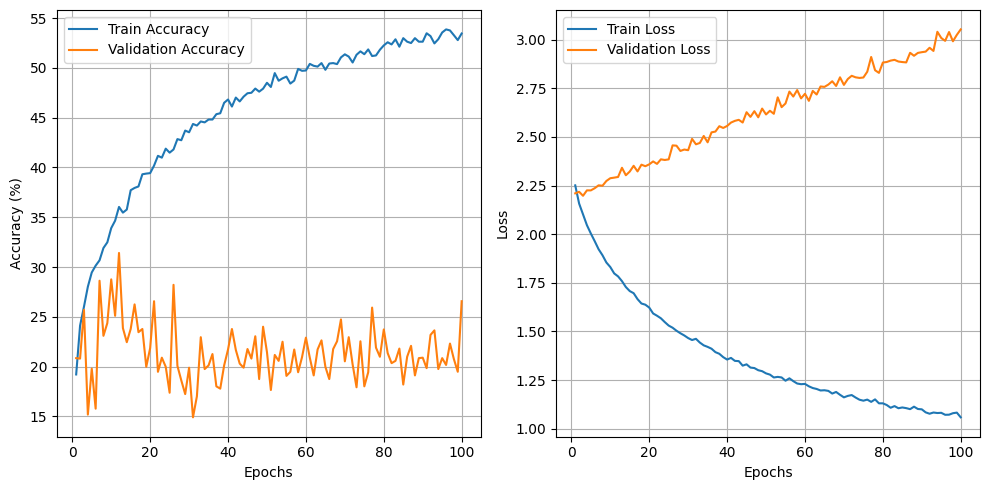

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), best_epoch_train_acc, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), best_epoch_val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), best_epoch_train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), best_epoch_val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(f'./Graficas_entrenamiento/v5/representacion_3/longitud_28/{nombre_modelo}.png')
plt.show()

***Cargar el modelo :***

In [10]:
#modelo = get_densenet121_model(num_classes=num_classes, pretrained=True).to(device)

modelo.load_state_dict(torch.load("./Modelos/v5/representacion_3/longitud_28/ResNet50_fold_4.pth"))
modelo.to(device)
modelo.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

***Evaluar el modelo :***

In [11]:
all_preds = []
all_labels = []

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelo(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

***Matriz de confusión :***

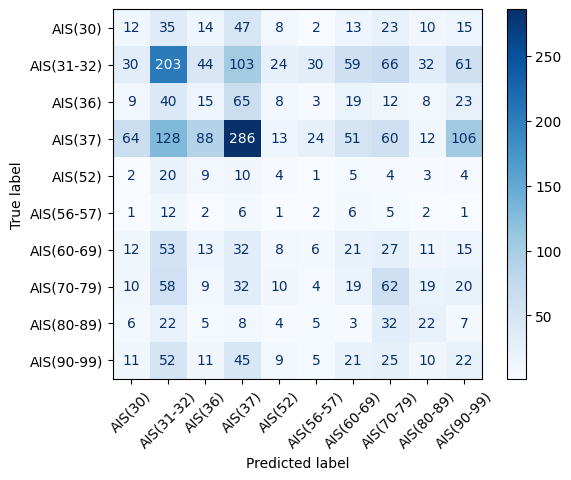

In [12]:
class_names = ['AIS(30)','AIS(31-32)','AIS(36)','AIS(37)','AIS(52)','AIS(56-57)','AIS(60-69)','AIS(70-79)','AIS(80-89)','AIS(90-99)']
#class_names = ['Cargo', 'Fishing', 'Military', 'Sailing', 'Tanker']
#class_names = ['Cargo','Container','Cruise','Fishing','Tanker']
#class_names = ['Cargo', 'Container','Tanker']
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

***Análisis de los resultados obtenidos :***

In [13]:
print(classification_report(all_labels, all_preds, target_names=class_names))

output_dir = Path('./Resultados/v5/representacion_3/longitud_28')

classification_text = classification_report(all_labels, all_preds, target_names=class_names)

with open(output_dir / 'ResNet50_report.txt', 'w') as f:
    f.write(classification_text)

              precision    recall  f1-score   support

     AIS(30)       0.08      0.07      0.07       179
  AIS(31-32)       0.33      0.31      0.32       652
     AIS(36)       0.07      0.07      0.07       202
     AIS(37)       0.45      0.34      0.39       832
     AIS(52)       0.04      0.06      0.05        62
  AIS(56-57)       0.02      0.05      0.03        38
  AIS(60-69)       0.10      0.11      0.10       198
  AIS(70-79)       0.20      0.26      0.22       243
  AIS(80-89)       0.17      0.19      0.18       114
  AIS(90-99)       0.08      0.10      0.09       211

    accuracy                           0.24      2731
   macro avg       0.15      0.16      0.15      2731
weighted avg       0.26      0.24      0.25      2731

